In [1]:
import pandas as pd
import numpy as np
from transformers import DebertaTokenizer, DebertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime

# Suppress expected warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.cluster._supervised')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.feature_selection')

# Add GPU count check at the top level
def get_available_gpus():
    """Get the number of available GPUs and their IDs"""
    if not torch.cuda.is_available():
        return 0, []
    
    n_gpus = torch.cuda.device_count()
    gpu_ids = list(range(n_gpus))
    return n_gpus, gpu_ids

def reduce_tokens_simple_truncation(text, tokenizer, max_length=512):
    """
    Simply truncate text to the maximum allowed token length.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text
    """
    tokens = tokenizer(text, truncation=True, max_length=max_length)
    return tokenizer.decode(tokens['input_ids'], skip_special_tokens=True)

def reduce_tokens_smart_truncation(text, tokenizer, max_length=512):
    """
    Intelligently truncate text by keeping the beginning and end portions.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Truncated text with beginning and end portions
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Keep beginning and end portions (prioritize beginning slightly)
    beginning_length = max_length // 2 + 50  # Keep slightly more from beginning
    end_length = max_length - beginning_length - 1  # Reserve 1 for separator
    
    beginning_tokens = tokens[:beginning_length]
    end_tokens = tokens[-end_length:]
    
    # Combine with a separator token
    beginning_text = tokenizer.decode(beginning_tokens, skip_special_tokens=True)
    end_text = tokenizer.decode(end_tokens, skip_special_tokens=True)
    
    return f"{beginning_text} [...] {end_text}"

def reduce_tokens_extractive_summarization(text, tokenizer, max_length=512):
    """
    Reduce text length using extractive summarization techniques.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Summarized text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # Import NLTK for sentence tokenization
    try:
        import nltk
        from nltk.tokenize import sent_tokenize
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
    except ImportError:
        # If NLTK is not available, fall back to smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Split text into sentences
    sentences = sent_tokenize(text)
    
    if len(sentences) <= 3:
        # Not enough sentences to summarize meaningfully, use smart truncation
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Get sentence token lengths
    sentence_tokens = []
    for sentence in sentences:
        tokens = tokenizer(sentence, return_tensors="pt")["input_ids"][0]
        sentence_tokens.append((sentence, len(tokens)))
    
    # Calculate target ratio based on max length vs total length
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    reduction_ratio = max_length / len(tokens)
    
    # Always keep first and last sentences
    first_sentence, first_len = sentence_tokens[0]
    last_sentence, last_len = sentence_tokens[-1]
    
    remaining_length = max_length - first_len - last_len - 10  # Reserve some tokens for separators
    
    # If can't even fit first and last sentences, use smart truncation
    if remaining_length <= 0:
        return reduce_tokens_smart_truncation(text, tokenizer, max_length)
    
    # Choose middle sentences based on importance (for now, just choose evenly distributed sentences)
    middle_sentences = sentence_tokens[1:-1]
    
    # Calculate how many middle sentences we can include
    middle_sentences_to_keep = []
    current_length = 0
    
    # Select sentences in a distributed manner
    if len(middle_sentences) > 0:
        # Fix: Add a check to prevent division by zero
        sentences_to_keep = int(reduction_ratio * len(middle_sentences))
        if sentences_to_keep <= 0:
            step = len(middle_sentences) + 1  # This will select only the first sentence if any
        else:
            step = max(1, len(middle_sentences) // sentences_to_keep)
            
        for i in range(0, len(middle_sentences), step):
            sentence, length = middle_sentences[i]
            if current_length + length <= remaining_length:
                middle_sentences_to_keep.append(sentence)
                current_length += length
            else:
                break
    
    # Combine sentences
    summarized_text = first_sentence
    
    if middle_sentences_to_keep:
        summarized_text += " " + " ".join(middle_sentences_to_keep)
    
    summarized_text += " " + last_sentence
    
    # Verify final length is within limit
    final_tokens = tokenizer(summarized_text, truncation=False, return_tensors="pt")["input_ids"][0]
    if len(final_tokens) > max_length:
        # Fall back to smart truncation if still too long
        return reduce_tokens_smart_truncation(summarized_text, tokenizer, max_length)
    
    return summarized_text

def reduce_tokens_hybrid(text, tokenizer, max_length=512):
    """
    Use a hybrid approach combining extractive summarization and smart truncation.
    
    Args:
        text (str): Input text
        tokenizer: Tokenizer to use
        max_length (int): Maximum token length
        
    Returns:
        str: Processed text
    """
    tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
    
    if len(tokens) <= max_length:
        return text
    
    # For very long documents, use extractive summarization first
    if len(tokens) > max_length * 2:
        summarized = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        summarized_tokens = tokenizer(summarized, truncation=False, return_tensors="pt")["input_ids"][0]
        
        # If still too long, apply smart truncation
        if len(summarized_tokens) > max_length:
            return reduce_tokens_smart_truncation(summarized, tokenizer, max_length)
        return summarized
    
    # For moderately long documents, use smart truncation directly
    return reduce_tokens_smart_truncation(text, tokenizer, max_length)

def process_with_token_reduction(texts, tokenizer, max_length=512, strategy="smart_truncation"):
    """
    Process a series of texts by applying token reduction where necessary.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        max_length (int): Maximum token length (default: 512)
        strategy (str): Token reduction strategy, one of:
            - "simple": Simple truncation at max_length
            - "smart_truncation": Keep beginning and end portions
            - "extractive_summarization": Use extractive summarization
            - "hybrid": Combine summarization and smart truncation
            
    Returns:
        pd.Series: Series with processed texts
    """
    processed_texts = []
    token_lengths_before = []
    token_lengths_after = []
    
    for text in tqdm(texts, desc=f"Applying token reduction ({strategy})"):
        # Calculate original token length
        tokens = tokenizer(text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_before.append(len(tokens))
        
        # Only process if longer than max_length
        if len(tokens) <= max_length:
            processed_texts.append(text)
            token_lengths_after.append(len(tokens))
            continue
        
        # Apply selected strategy
        if strategy == "simple":
            processed_text = reduce_tokens_simple_truncation(text, tokenizer, max_length)
        elif strategy == "smart_truncation":
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        elif strategy == "extractive_summarization":
            processed_text = reduce_tokens_extractive_summarization(text, tokenizer, max_length)
        elif strategy == "hybrid":
            processed_text = reduce_tokens_hybrid(text, tokenizer, max_length)
        else:
            # Default to smart truncation
            processed_text = reduce_tokens_smart_truncation(text, tokenizer, max_length)
        
        processed_texts.append(processed_text)
        
        # Calculate new token length
        new_tokens = tokenizer(processed_text, truncation=False, return_tensors="pt")["input_ids"][0]
        token_lengths_after.append(len(new_tokens))
    
    # Print statistics
    print(f"\nToken reduction statistics using {strategy} strategy:")
    print(f"  Before:")
    print(f"    Mean length: {np.mean(token_lengths_before):.2f}")
    print(f"    Median length: {np.median(token_lengths_before):.2f}")
    print(f"    Max length: {max(token_lengths_before)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_before if l > max_length)} ({sum(1 for l in token_lengths_before if l > max_length)/len(token_lengths_before)*100:.2f}%)")
    
    print(f"  After:")
    print(f"    Mean length: {np.mean(token_lengths_after):.2f}")
    print(f"    Median length: {np.median(token_lengths_after):.2f}")
    print(f"    Max length: {max(token_lengths_after)}")
    print(f"    Docs exceeding {max_length} tokens: {sum(1 for l in token_lengths_after if l > max_length)} ({sum(1 for l in token_lengths_after if l > max_length)/len(token_lengths_after)*100:.2f}%)")
    
    # Optional: Create histogram plot
    try:
        plt.figure(figsize=(10, 6))
        plt.hist([token_lengths_before, token_lengths_after], bins=30, 
                 label=['Before reduction', 'After reduction'], alpha=0.7)
        plt.axvline(x=max_length, color='r', linestyle='--', label=f'Max length ({max_length})')
        plt.title(f'Token Length Distribution Before and After {strategy}')
        plt.xlabel('Number of Tokens')
        plt.ylabel('Frequency')
        plt.legend()
        plt.savefig(f'token_reduction_{strategy}.png')
        plt.close()
        print(f"  Distribution plot saved as token_reduction_{strategy}.png")
    except Exception as e:
        print(f"  Could not create distribution plot: {str(e)}")
    
    return pd.Series(processed_texts, index=texts.index)

def calculate_token_lengths(texts, tokenizer):
    """
    Calculate the token length for each text sample using the specified tokenizer.
    
    Args:
        texts (pd.Series): Series of input texts
        tokenizer: Tokenizer to use for tokenization
        
    Returns:
        pd.Series: Series containing the token length of each text
    """
    token_lengths = []
    for text in tqdm(texts, desc="Calculating token lengths"):
        tokens = tokenizer(str(text), truncation=False, return_tensors="pt")
        token_lengths.append(len(tokens['input_ids'][0]))
    
    return pd.Series(token_lengths, index=texts.index)

def filter_outliers_by_token_length(texts, token_lengths, std_threshold=3.0, min_token_threshold=None):
    """
    Filter out text samples with token lengths beyond a certain standard deviation threshold.
    
    Args:
        texts (pd.Series): Series of input texts
        token_lengths (pd.Series): Series containing token length of each text
        std_threshold (float): Standard deviation threshold (default: 3.0)
        min_token_threshold (int, optional): Minimum number of tokens required (default: None)
        
    Returns:
        tuple: Filtered texts and boolean mask to apply to original data
    """
    mean_length = token_lengths.mean()
    std_length = token_lengths.std()
    
    # Print original token statistics
    print(f"Token length statistics before filtering:")
    print(f"  Mean: {mean_length:.2f}, Std Dev: {std_length:.2f}")
    print(f"  Min: {token_lengths.min()}, Max: {token_lengths.max()}")
    print(f"  25th percentile: {token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {token_lengths.quantile(0.75):.2f}")
    
    # Original data size
    original_size = len(texts)
    
    # Start with all True mask for the original data
    final_mask = pd.Series(True, index=texts.index)
    
    # Step 1: Apply standard deviation filtering if std_threshold is provided
    if std_threshold < float('inf'):
        # Define upper and lower bounds
        upper_bound = mean_length + std_threshold * std_length
        lower_bound = mean_length - std_threshold * std_length
        lower_bound = max(1, lower_bound)  # Ensure lower bound is at least 1
        
        # Create mask for samples within bounds
        std_mask = (token_lengths >= lower_bound) & (token_lengths <= upper_bound)
        
        # Update final mask with standard deviation condition
        final_mask = final_mask & std_mask
        
        std_removed = (~std_mask).sum()
        print(f"Applied {std_threshold} std dev threshold: ({lower_bound:.2f}, {upper_bound:.2f})")
        print(f"Removed {std_removed} samples by std dev filtering ({std_removed/original_size*100:.2f}% of data)")
    
    # Step 2: Apply minimum token threshold if specified
    if min_token_threshold is not None:
        # Create mask for minimum token threshold
        min_token_mask = token_lengths >= min_token_threshold
        
        # Track how many would be removed by this filter
        min_token_removed = (~min_token_mask).sum()
        
        # Track how many would be removed by this filter that weren't already filtered by std
        additional_removed = ((~min_token_mask) & final_mask).sum()
        
        # Update final mask with minimum token threshold condition
        final_mask = final_mask & min_token_mask
        
        print(f"Applied minimum token threshold of {min_token_threshold}")
        print(f"Removed {min_token_removed} samples below minimum token threshold ({min_token_removed/original_size*100:.2f}% of original data)")
        print(f"Of which {additional_removed} weren't already filtered by std deviation ({additional_removed/original_size*100:.2f}% of original data)")
    
    # Apply final mask to get filtered data
    filtered_texts = texts[final_mask]
    filtered_token_lengths = token_lengths[final_mask]
    
    # Calculate total removed
    total_removed = (~final_mask).sum()
    print(f"Total removed: {total_removed} samples ({total_removed/original_size*100:.2f}% of original data)")
    print(f"Remaining: {final_mask.sum()} samples ({final_mask.sum()/original_size*100:.2f}% of original data)")

    # Print final statistics
    print(f"\nToken length statistics after all filtering:")
    print(f"  Mean: {filtered_token_lengths.mean():.2f}, Std Dev: {filtered_token_lengths.std():.2f}")
    print(f"  Min: {filtered_token_lengths.min()}, Max: {filtered_token_lengths.max()}")
    print(f"  25th percentile: {filtered_token_lengths.quantile(0.25):.2f}")
    print(f"  50th percentile (median): {filtered_token_lengths.quantile(0.5):.2f}")
    print(f"  75th percentile: {filtered_token_lengths.quantile(0.75):.2f}")
    
    return filtered_texts, final_mask

class IssueDataset(Dataset):
    """
    Dataset for processing text data and multi-label classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded for multi-label).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        
        # For multi-label classification, ensure we're passing the full label array
        # and not just a single value
        label = self.labels[idx]
        
        # Make sure we're getting a proper multi-dimensional label array
        # and not flattening it incorrectly
        if isinstance(label, (list, np.ndarray)):
            # Convert directly to tensor without modifying shape
            label = torch.tensor(label, dtype=torch.float)
        else:
            # If it's not already an array-like structure, this is likely a mistake
            # as we expect multi-label one-hot encoded data
            raise ValueError(f"Expected multi-dimensional label array but got {type(label)}")
        
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': label
        }
    
class DeBERTaCNNClassifier(nn.Module):
    """
    A hybrid classifier model based on DeBERTa and CNN for multi-label classification.
    
    This model uses a pre-trained DeBERTa model as the encoder to generate embeddings,
    followed by a CNN layer for feature extraction, pooling for feature summarization,
    and a fully connected layer for classification.
    
    The architecture consists of:
    1. Embedding layer (DeBERTa)
    2. Convolutional layers with multiple filter sizes
    3. Max pooling layer
    4. Fully connected layer for classification
    
    Args:
        num_labels (int): Number of classes in the multi-label classification task.
        filter_sizes (list): List of filter sizes for CNN layers (default: [2, 3, 4, 5])
        num_filters (int): Number of filters per size (default: 128)
    """
    def __init__(self, num_labels, filter_sizes=[2, 3, 4, 5], num_filters=128):
        super().__init__()
        # Load pre-trained DeBERTa model
        self.deberta = DebertaModel.from_pretrained('microsoft/deberta-base')
        hidden_size = 768  # DeBERTa hidden size
        
        # Freeze all parameters in DeBERTa
        for param in self.deberta.parameters():
            param.requires_grad = False
        # Unfreeze encoder parameters for fine-tuning
        # We'll unfreeze the last 3 encoder layers
        for layer in self.deberta.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True
        
        # CNN layers with multiple filter sizes
        self.convs = nn.ModuleList([
            nn.Conv2d(
                in_channels=1,
                out_channels=num_filters,
                kernel_size=(filter_size, hidden_size),
                stride=1
            )
            for filter_size in filter_sizes
        ])
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # Output layer - concatenate all CNN outputs
        self.classifier = nn.Linear(len(filter_sizes) * num_filters, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get DeBERTa embeddings
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the entire sequence output (not just the [CLS] token)
        sequence_output = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        
        # Add a channel dimension for CNN
        x = sequence_output.unsqueeze(1)  # Shape: (batch_size, 1, seq_len, hidden_size)
        
        # Apply CNN with different filter sizes and max-over-time pooling
        pooled_outputs = []
        for conv in self.convs:
            # Apply convolution
            # Conv shape: (batch_size, num_filters, seq_len-filter_size+1, 1)
            conv_output = conv(x).squeeze(3)
            
            # Apply ReLU
            conv_output = torch.relu(conv_output)
            
            # Apply max-over-time pooling
            # Pooled shape: (batch_size, num_filters, 1)
            pooled = nn.functional.max_pool1d(
                conv_output, 
                kernel_size=conv_output.shape[2]
            ).squeeze(2)
            
            pooled_outputs.append(pooled)
        
        # Concatenate the outputs from different filter sizes
        # Combined shape: (batch_size, num_filters * len(filter_sizes))
        x = torch.cat(pooled_outputs, dim=1)
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply the classifier
        return self.classifier(x)

# Alias to maintain backwards compatibility
DeBERTaClassifier = DeBERTaCNNClassifier
    
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For multi-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False


def train_epoch(model, loader, criterion, optimizer, device, threshold=0.5, early_stopping=None):
    """
    Train the model for one epoch, computing loss and metrics for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        threshold (float): Threshold for binary predictions (default is 0.5).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, Hamming accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        # Apply sigmoid and threshold for predictions
        predictions = torch.sigmoid(outputs) >= threshold
        all_preds.append(predictions.cpu().detach().numpy())
        all_labels.append(labels.cpu().detach().numpy())
    
    # Calculate metrics for multi-label classification
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Use subset accuracy (exact match) for a strict measure
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    avg_loss = total_loss / len(loader)
    
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, exact_match, True
            
    return avg_loss, exact_match, False
    

def validate(model, loader, criterion, device, threshold=0.5):
    """
    Evaluate the model on provided validation data for multi-label classification.

    Args:
        model (nn.Module): The multi-label classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function (BCEWithLogitsLoss).
        device: Device to perform evaluation.
        threshold (float): Threshold for binary predictions (default is 0.5).

    Returns:
        tuple: Average loss, various accuracy metrics, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Apply sigmoid and threshold for predictions
            predictions = (torch.sigmoid(outputs) >= threshold).float()
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    # Calculate different multi-label metrics
    
    # 1. Exact Match / Subset Accuracy (all labels must be correct)
    exact_match = (all_preds == all_labels).all(axis=1).mean()
    
    # 2. Partial Match Accuracy (only count correctly predicted 1s, ignore 0s)
    # Calculate true positives per sample
    true_positives = np.logical_and(all_preds == 1, all_labels == 1).sum(axis=1)
    # Calculate total actual positives per sample
    total_positives = (all_labels == 1).sum(axis=1)
    # Handle division by zero - samples with no positive labels get a score of 0
    partial_match = np.zeros_like(true_positives, dtype=float)
    # Only calculate ratio for samples with at least one positive label
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # 3. Jaccard Similarity (intersection over union)
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        # Create a float array for output to avoid type casting error
        result = np.zeros_like(intersection, dtype=float)
        # Avoid division by zero
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(all_labels.astype(bool), all_preds.astype(bool))
    
    # Add Hamming metric - this is the same as partial_match_accuracy
    hamming_sim = partial_match_accuracy
    
    # Sample-based metrics - Each sample contributes equally regardless of number of labels
    precision = precision_score(all_labels, all_preds, average='samples', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='samples', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    
    return (total_loss / len(loader), 
            {"exact_match": exact_match, 
             "partial_match": partial_match_accuracy,
             "hamming": hamming_sim,
             "jaccard": jaccard_sim}, 
            precision, recall, f1)

def plot_multilabel_confusion_matrix(y_true, y_pred, class_names):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    
    Args:
        y_true (numpy.ndarray): True binary labels.
        y_pred (numpy.ndarray): Predicted binary labels.
        class_names (list): Names of the classes/labels.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])  # Make it indexable for single class
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:  # Ensure we don't exceed the number of classes
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    # Hide any unused subplots
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    return fig

def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0, tokenizer=None, token_std_threshold=None, min_token_threshold=None):
    """
    Filter out infrequent labels, samples with too many labels, and token length outliers.
    
    Args:
        df (pd.DataFrame): DataFrame with text column and 'labels'
        text_column (str): Name of the column containing the text data to use
        min_label_freq (int): Minimum frequency for a label to be considered frequent.
        max_label_len (int): Maximum number of labels per sample.
        min_label_comb_freq (int): Minimum frequency for a label combination to be kept.
        tokenizer: Tokenizer to use for token length calculation (required if token_std_threshold is provided)
        token_std_threshold (float, optional): Standard deviation threshold for filtering token length outliers.
            If None, no token length filtering is applied. Common values are 2.0 or 3.0.
        min_token_threshold (int, optional): Minimum number of tokens required for a sample.
            If None, no minimum token threshold is applied.

    Returns:
        tuple: Filtered texts and labels.
    """
    # Print initial dataset size
    initial_size = len(df)
    print(f"\n=== DATA PREPROCESSING STATISTICS ===")
    print(f"Initial dataset size: {initial_size}")
    
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        before_nan_filter = len(df)
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
        nan_removed = before_nan_filter - len(df)
        if nan_removed > 0:
            print(f"Step 1: Removed {nan_removed} rows with 'nan' text ({nan_removed/before_nan_filter*100:.2f}% of data)")
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    before_na_drop = len(df)
    df = df.dropna()
    na_removed = before_na_drop - len(df)
    if na_removed > 0:
        print(f"Step 2: Removed {na_removed} rows with missing labels ({na_removed/before_na_drop*100:.2f}% of data)")
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    current_size = len(texts)
    print(f"Dataset size after basic cleaning: {current_size} ({current_size/initial_size*100:.2f}% of original data)")

    # Filter by token length if requested
    if (token_std_threshold is not None or min_token_threshold is not None) and tokenizer is not None:
        print(f"\nStep 3: Filtering by token length...")
        if token_std_threshold is not None:
            print(f"Using {token_std_threshold} standard deviation threshold")
        if min_token_threshold is not None:
            print(f"Using minimum token threshold of {min_token_threshold}")
        
        # Calculate token lengths
        token_lengths = calculate_token_lengths(texts, tokenizer)
        
        # Apply token length filtering
        before_token_filter = len(texts)
        filtered_texts, token_mask = filter_outliers_by_token_length(
            texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=min_token_threshold
        )
        # Apply same filter to labels
        filtered_labels = labels[token_mask].reset_index(drop=True)
        token_removed = before_token_filter - len(filtered_texts)
        print(f"Removed {token_removed} samples by token length filtering ({token_removed/before_token_filter*100:.2f}% of data)")
        print(f"Texts after token length filtering: {len(filtered_texts)} ({len(filtered_texts)/initial_size*100:.2f}% of original data)")

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])
    total_labels_before = len(label_distribution)
    print(f"\nStep 4: Filtering infrequent labels (min frequency: {min_label_freq})")
    print(f"Total unique labels before filtering: {total_labels_before}")

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    labels_removed = total_labels_before - len(frequent_labels)
    print(f"Removed {labels_removed} infrequent labels ({labels_removed/total_labels_before*100:.2f}% of labels)")
    print(f"Number of labels remaining: {len(frequent_labels)} ({len(frequent_labels)/total_labels_before*100:.2f}% of labels)")

    # Filter out infrequent labels
    before_label_filter = len(labels)
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    
    # Count samples that have no labels after filtering
    empty_labels_mask = filtered_labels.apply(len) > 0
    empty_labels_count = (~empty_labels_mask).sum()
    if empty_labels_count > 0:
        print(f"Warning: {empty_labels_count} samples ({empty_labels_count/before_label_filter*100:.2f}%) now have no labels due to label frequency filtering")
        # Remove samples with no labels
        filtered_labels = filtered_labels[empty_labels_mask]
        texts = texts[empty_labels_mask]
        print(f"Removed {empty_labels_count} samples with no labels")
    
    print(f"Samples remaining after label filtering: {len(filtered_labels)} ({len(filtered_labels)/before_label_filter*100:.2f}% of data)")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    total_combinations_before = len(label_combinations)
    
    print(f"\nStep 5: Filtering infrequent label combinations (min frequency: {min_label_comb_freq})")
    print(f"Total unique label combinations before filtering: {total_combinations_before}")
    
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    combinations_removed = total_combinations_before - len(frequent_combinations)
    print(f"Removed {combinations_removed} infrequent label combinations ({combinations_removed/total_combinations_before*100:.2f}% of combinations)")
    print(f"Number of label combinations remaining: {len(frequent_combinations)} ({len(frequent_combinations)/total_combinations_before*100:.2f}% of combinations)")
    
    # Create mask for samples with frequent label combinations (if min_label_comb_freq > 0)
    if min_label_comb_freq > 0:
        before_comb_filter = len(filtered_labels)
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        samples_removed_by_comb = before_comb_filter - comb_mask.sum()
        print(f"Removed {samples_removed_by_comb} samples with infrequent label combinations ({samples_removed_by_comb/before_comb_filter*100:.2f}% of data)")
        print(f"Samples remaining after combination filtering: {comb_mask.sum()} ({comb_mask.sum()/before_comb_filter*100:.2f}% of data)")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    print(f"\nStep 6: Filtering samples with too many labels (max labels per sample: {max_label_len})")
    before_length_filter = len(filtered_labels)
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    samples_removed_by_length = before_length_filter - length_mask.sum()
    print(f"Removed {samples_removed_by_length} samples with too many or zero labels ({samples_removed_by_length/before_length_filter*100:.2f}% of data)")
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"\n=== FINAL PREPROCESSING RESULTS ===")
    print(f"Original dataset size: {initial_size}")
    print(f"Final dataset size: {len(filtered_labels)} ({len(filtered_labels)/initial_size*100:.2f}% of original data)")
    print(f"Total samples removed: {initial_size - len(filtered_labels)} ({(initial_size - len(filtered_labels))/initial_size*100:.2f}% of original data)")
    
    return texts, filtered_labels



def main(args):
    """
    Main function to run the multi-label classification pipeline with DeBERTa.
    This function loads both training and testing data from CSV files, preprocesses them, 
    trains the model, and evaluates performance.
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Check for GPU availability
    n_gpus, gpu_ids = get_available_gpus()
    if n_gpus >= 2:
        print(f"Using {n_gpus} GPUs: {gpu_ids}")
        device = torch.device("cuda")
        use_multi_gpu = True
    elif n_gpus == 1:
        print("Using 1 GPU")
        device = torch.device("cuda")
        use_multi_gpu = False
    else:
        print("No GPUs available, using CPU")
        device = torch.device("cpu")
        use_multi_gpu = False
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"deberta_cnn_run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Initialize tokenizer early
    print("Loading tokenizer...")
    tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

    # Determine token standard deviation threshold from argument
    token_std_threshold = None
    if args.token_length_filter == '2std':
        token_std_threshold = 2.0
    elif args.token_length_filter == '3std':
        token_std_threshold = 3.0

    # Load training data
    print(f"Loading training data from {args.train_data_path}...")
    train_df = pd.read_csv(args.train_data_path)
    
    # Convert string representation of list to actual list for labels column
    if 'labels' in train_df.columns:
        try:
            # Safe evaluation for string representations of lists
            train_df['labels'] = train_df['labels'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.strip() not in ('', 'nan', 'None', 'NaN') else 
                          ([] if pd.isna(x) else x)
            )
        except Exception as e:
            print(f"Error processing training labels: {e}")
            print("First few labels for inspection:", train_df['labels'].head())
            raise
    else:
        raise ValueError(f"'labels' column not found in training data. Available columns: {train_df.columns.tolist()}")
    
    print(f"Loading testing data from {args.test_data_path}...")
    test_df = pd.read_csv(args.test_data_path)
    
    # Convert string representation of list to actual list for labels column
    if 'labels' in test_df.columns:
        try:
            # Safe evaluation for string representations of lists
            test_df['labels'] = test_df['labels'].apply(
                lambda x: eval(x) if isinstance(x, str) and x.strip() not in ('', 'nan', 'None', 'NaN') else 
                          ([] if pd.isna(x) else x)
            )
        except Exception as e:
            print(f"Error processing testing labels: {e}")
            print("First few labels for inspection:", test_df['labels'].head())
            raise
    else:
        raise ValueError(f"'labels' column not found in testing data. Available columns: {test_df.columns.tolist()}")
    
    # Check if the text column exists in both datasets
    if args.text_column not in train_df.columns or args.text_column not in test_df.columns:
        available_columns_train = [col for col in train_df.columns if col.startswith('all_text')]
        available_columns_test = [col for col in test_df.columns if col.startswith('all_text')]
        common_columns = list(set(available_columns_train) & set(available_columns_test))
        
        print(f"Text column '{args.text_column}' not found in both datasets.")
        print(f"Common text columns: {common_columns}")
        
        if len(common_columns) == 0:
            raise ValueError("No common text columns found in both datasets")
        
        args.text_column = common_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Process training data
    print("\n=== PROCESSING TRAINING DATA ===")
    
    # Extract issue texts and labels from training data
    train_texts = train_df[args.text_column]
    train_labels = train_df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Apply token length filtering to training data if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering to training data...")
        token_lengths = calculate_token_lengths(train_texts, tokenizer)
        
        # Filter by standard deviation, then by min threshold (in sequence)
        filtered_train_texts, token_mask = filter_outliers_by_token_length(
            train_texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe
        filtered_train_labels = train_labels[token_mask]
        filtered_train_df = train_df[token_mask]
        
        # Reset indices for further processing
        train_texts = filtered_train_texts.reset_index(drop=True)
        train_labels = filtered_train_labels.reset_index(drop=True)
        filtered_train_df = filtered_train_df.reset_index(drop=True)
    else:
        filtered_train_df = train_df
    
    # Apply token reduction to training data if requested
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy to training data: {args.token_reduction_strategy}")
        train_texts = process_with_token_reduction(
            train_texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_train_df with the reduced texts
        filtered_train_df[args.text_column] = train_texts
    
    # Use prepare_data to filter and prepare training data
    train_texts, train_filtered_labels = prepare_data(
        filtered_train_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Skip token filtering as we've done it
        min_token_threshold=None   # Skip token threshold as we've done it
    )
    
    # Print training dataset statistics
    print("\n=== TRAINING DATASET STATISTICS ===")
    print(f"Initial training dataset size: {len(train_df)}")
    print(f"Final training dataset size: {len(train_texts)}")
    print(f"Total samples removed: {len(train_df) - len(train_texts)} ({(len(train_df) - len(train_texts))/len(train_df)*100:.2f}% of original training data)")
    
    # Count the number of labels distribution in training data
    train_label_distribution = Counter([label for labels in train_filtered_labels for label in labels])
    print('\nTraining Label Distribution:')
    for i, (label, count) in enumerate(sorted(train_label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Process testing data
    print("\n=== PROCESSING TESTING DATA ===")
    
    # Extract issue texts and labels from testing data
    test_texts = test_df[args.text_column]
    test_labels = test_df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists
    
    # Apply token length filtering to testing data if requested
    if token_std_threshold is not None or args.min_token_threshold is not None:
        print(f"\nApplying token length filtering to testing data...")
        token_lengths = calculate_token_lengths(test_texts, tokenizer)
        
        # Use the same filtering parameters as for training data
        filtered_test_texts, token_mask = filter_outliers_by_token_length(
            test_texts, 
            token_lengths, 
            std_threshold=token_std_threshold if token_std_threshold is not None else float('inf'),
            min_token_threshold=args.min_token_threshold
        )
        
        # Apply same filter to labels and dataframe
        filtered_test_labels = test_labels[token_mask]
        filtered_test_df = test_df[token_mask]
        
        # Reset indices for further processing
        test_texts = filtered_test_texts.reset_index(drop=True)
        test_labels = filtered_test_labels.reset_index(drop=True)
        filtered_test_df = filtered_test_df.reset_index(drop=True)
    else:
        filtered_test_df = test_df
    
    # Apply token reduction to testing data if requested
    if args.token_reduction_strategy:
        print(f"\nApplying token reduction strategy to testing data: {args.token_reduction_strategy}")
        test_texts = process_with_token_reduction(
            test_texts, 
            tokenizer, 
            max_length=args.max_length, 
            strategy=args.token_reduction_strategy
        )
        # Update filtered_test_df with the reduced texts
        filtered_test_df[args.text_column] = test_texts
    
    # Use prepare_data to filter and prepare testing data
    # Note: We use the same min_label_freq, max_label_len etc. as training data for consistency
    test_texts, test_filtered_labels = prepare_data(
        filtered_test_df,
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq,
        tokenizer=tokenizer,
        token_std_threshold=None,  # Skip token filtering as we've done it
        min_token_threshold=None   # Skip token threshold as we've done it
    )
    
    # Print testing dataset statistics
    print("\n=== TESTING DATASET STATISTICS ===")
    print(f"Initial testing dataset size: {len(test_df)}")
    print(f"Final testing dataset size: {len(test_texts)}")
    print(f"Total samples removed: {len(test_df) - len(test_texts)} ({(len(test_df) - len(test_texts))/len(test_df)*100:.2f}% of original testing data)")
    
    # Save preprocessing metadata
    preprocessing_metadata = {
        'data_format': 'csv',
        'data_paths': {
            'train': args.train_data_path,
            'test': args.test_data_path
        },
        'initial_dataset_sizes': {
            'train': len(train_df),
            'test': len(test_df)
        },
        'final_dataset_sizes': {
            'train': len(train_texts),
            'test': len(test_texts)
        },
        'token_reduction': {
            'applied': args.token_reduction_strategy is not None,
            'strategy': args.token_reduction_strategy if args.token_reduction_strategy else None,
            'max_length': args.max_length
        },
        'token_length_filtering': {
            'applied': token_std_threshold is not None,
            'threshold': token_std_threshold
        },
        'label_filtering': {
            'min_label_freq': args.min_label_freq,
            'max_label_len': args.max_label_len,
            'min_label_comb_freq': args.min_label_comb_freq
        },
        'min_token_threshold': {
            'applied': args.min_token_threshold is not None,
            'threshold': args.min_token_threshold
        },
        'predefined_labels': {
            'applied': args.use_predefined_labels,
            'num_labels': args.num_labels if args.use_predefined_labels else None
        }
    }
    
    # Explicitly calculate token lengths after preparation for metadata
    print("Calculating final token lengths for metadata...")
    train_token_lengths = calculate_token_lengths(train_texts, tokenizer)
    test_token_lengths = calculate_token_lengths(test_texts, tokenizer)
    
    # Calculate and add token statistics to metadata
    if tokenizer is not None:
        preprocessing_metadata['token_stats'] = {
            'train': {
                'max_token_length': int(train_token_lengths.max()),
                'mean_token_length': float(train_token_lengths.mean()),
                'median_token_length': float(train_token_lengths.median())
            },
            'test': {
                'max_token_length': int(test_token_lengths.max()),
                'mean_token_length': float(test_token_lengths.mean()),
                'median_token_length': float(test_token_lengths.median())
            }
        }
        
        print(f"\n=== TOKEN LENGTH SUMMARY ===")
        print(f"Training set:")
        print(f"  Maximum token length: {train_token_lengths.max()}")
        print(f"  Mean token length: {train_token_lengths.mean():.2f}")
        print(f"  Median token length: {train_token_lengths.median():.2f}")
        
        print(f"Testing set:")
        print(f"  Maximum token length: {test_token_lengths.max()}")
        print(f"  Mean token length: {test_token_lengths.mean():.2f}")
        print(f"  Median token length: {test_token_lengths.median():.2f}")
    
    with open(os.path.join(run_dir, 'preprocessing_metadata.json'), 'w') as f:
        json.dump(preprocessing_metadata, f, indent=4)
    
    # Encode multi-labels using MultiLabelBinarizer - fit on training data only
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    train_labels_encoded = mlb.fit_transform(train_filtered_labels)
    
    # Transform test labels using the same encoder
    test_labels_encoded = mlb.transform(test_filtered_labels)
    
    # Save all original label classes
    all_classes = mlb.classes_.tolist()
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': all_classes
        }, f)
    
    # Calculate label distribution
    label_counts = train_labels_encoded.sum(axis=0)
    
    # Log class imbalance metrics for training set
    label_density = label_counts.sum() / (train_labels_encoded.shape[0] * train_labels_encoded.shape[1])
    print(f"Training set label density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / train_labels_encoded.shape[0]:.2f}")
    
    # Print hybrid feature selection args
    print(f"Using predefined labels: {args.use_predefined_labels}")
    
    # Optionally use a predefined list of 15 labels
    if args.use_predefined_labels:
        print(f"\nUsing predefined list of 15 labels...")
        
        # Predefined list of labels to use
        if args.num_labels == 10:
            predefined_labels = np.array([
                'area/cloudprovider', 
                'area/dependency', 
                'area/kubelet', 
                'area/apiserver', 
                'area/ipvs', 
                'area/security', 
                'area/provider/azure', 
                'area/kubectl', 
                'area/kube-proxy', 
                'area/code-generation'
            ])
        else:
            predefined_labels = np.array([
                'area/cloudprovider', 
                'area/dependency', 
                'area/kubelet', 
                'area/apiserver', 
                'area/ipvs', 
                'area/release-eng', 
                'area/provider/azure', 
                'area/kubectl', 
                'area/kube-proxy', 
                'area/code-generation',
                'area/kubeadm', 
                'area/test', 
                'area/provider/gcp', 
                'area/security', 
                'area/conformance'
            ])
        
        print(f"Using {len(predefined_labels)} predefined labels (from --num_labels={args.num_labels}): {predefined_labels}")
        
        # Find indices of predefined labels in the mlb.classes_
        selected_indices = []
        selected_labels = []
        
        for label in predefined_labels:
            if label in mlb.classes_:
                idx = np.where(mlb.classes_ == label)[0][0]
                selected_indices.append(idx)
                selected_labels.append(label)
        
        selected_indices = np.array(selected_indices)
        selected_labels = np.array(selected_labels)
        
        # In case some labels are not found, inform the user
        if len(selected_labels) < len(predefined_labels):
            missing_labels = set(predefined_labels) - set(selected_labels)
            print(f"Warning: {len(missing_labels)} labels were not found in the dataset: {missing_labels}")
            
        # If no labels were found, raise an error
        if len(selected_indices) == 0:
            raise ValueError("None of the predefined labels were found in the dataset!")
        
        # Filter labels_encoded to keep only selected labels
        train_labels_encoded = train_labels_encoded[:, selected_indices]
        test_labels_encoded = test_labels_encoded[:, selected_indices]
        
        # Filter out samples with no labels after feature selection
        train_labels_sum = train_labels_encoded.sum(axis=1)
        train_has_labels_mask = train_labels_sum > 0
        
        # Apply mask to training data
        train_texts = train_texts[train_has_labels_mask].reset_index(drop=True)
        train_labels_encoded = train_labels_encoded[train_has_labels_mask]
        
        # Also filter test data
        test_labels_sum = test_labels_encoded.sum(axis=1)
        test_has_labels_mask = test_labels_sum > 0
        
        # Apply mask to test data
        test_texts = test_texts[test_has_labels_mask].reset_index(drop=True)
        test_labels_encoded = test_labels_encoded[test_has_labels_mask]
        
        print(f"Removed {(~train_has_labels_mask).sum()} training samples with no labels after feature selection")
        print(f"Removed {(~test_has_labels_mask).sum()} testing samples with no labels after feature selection")
        print(f"Remaining training samples: {len(train_texts)}")
        print(f"Remaining testing samples: {len(test_texts)}")
        
        # Save selected labels to file
        with open(os.path.join(run_dir, 'selected_labels.json'), 'w') as f:
            json.dump({
                'selected_labels': selected_labels.tolist(),
                'selected_indices': selected_indices.tolist(),
                'selection_method': 'predefined_list'
            }, f)
        
        # Update mlb.classes_ to only contain selected classes
        mlb.classes_ = np.array(selected_labels)
        
        # Recalculate label counts with selected labels
        label_counts = train_labels_encoded.sum(axis=0)
        print(f"Training with {len(selected_labels)} selected labels: {selected_labels}")
    else:
        print(f"Using all {len(mlb.classes_)} labels from the dataset")
        print("Feature selection disabled, using all labels")
    
    print(f"Training samples: {len(train_texts)}, Testing samples: {len(test_texts)}")
    
    # Implement class weights for loss function to handle imbalance
    pos_weights = None
    if args.use_class_weights and label_counts.min() < label_counts.max() / 5:  # If there's significant imbalance
        print("Computing class weights for imbalanced labels...")
        pos_weights = torch.FloatTensor(
            (train_labels_encoded.shape[0] - label_counts) / label_counts
        ).clamp(0.5, 10).to(device)  # Limit range to prevent extreme weights
    
    # Create datasets and dataloaders
    batch_size = args.batch_size
    train_dataset = IssueDataset(train_texts, train_labels_encoded, tokenizer, max_length=args.max_length)
    test_dataset = IssueDataset(test_texts, test_labels_encoded, tokenizer, max_length=args.max_length)
    
    # Increase batch size for DataParallel if multiple GPUs
    if use_multi_gpu:
        batch_size = batch_size * n_gpus
        print(f"Using larger batch size of {batch_size} for {n_gpus} GPUs")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model, loss function, and optimizer
    print("Initializing model...")
    
    # Parse CNN filter sizes from string to list of integers
    if args.cnn_filter_sizes:
        filter_sizes = [int(size) for size in args.cnn_filter_sizes.split(',')]
        print(f"Using CNN filter sizes: {filter_sizes}")
    else:
        filter_sizes = [2, 3, 4, 5]  # Default filter sizes
        print(f"Using default CNN filter sizes: {filter_sizes}")
    
    # Initialize DeBERTa-CNN model
    model = DeBERTaCNNClassifier(
        num_labels=len(mlb.classes_),
        filter_sizes=filter_sizes,
        num_filters=args.cnn_num_filters
    ).to(device)
    
    print(f"Initialized DeBERTa-CNN model with {len(filter_sizes)} filter sizes and {args.cnn_num_filters} filters per size")
    
    # Use DataParallel for multiple GPUs
    if use_multi_gpu:
        model = nn.DataParallel(model)
        print("Model wrapped in DataParallel")
    
    # Use weighted loss if we have weights
    if pos_weights is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
        print("Using weighted BCE loss")
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.learning_rate)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=args.patience, min_delta=0.01)
    
    # Training loop
    num_epochs = args.epochs
    print(f"Starting training for {num_epochs} epochs...")
    
    train_losses = []
    test_losses = []
    best_f1 = 0.0
    best_model_saved = False  # Flag to track if we've saved at least one model
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Train for one epoch
        train_loss, train_acc, stop_early = train_epoch(
            model, train_loader, criterion, optimizer, device, early_stopping=early_stopping
        )
        
        # Evaluate on test data
        test_loss, accuracy_metrics, test_precision, test_recall, test_f1 = validate(
            model, test_loader, criterion, device
        )
        
        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy (Exact Match): {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy (Exact Match): {accuracy_metrics['exact_match']:.4f}")
        print(f"Test Accuracy (Partial Match): {accuracy_metrics['partial_match']:.4f}")
        print(f"Test Accuracy (Jaccard): {accuracy_metrics['jaccard']:.4f}")
        print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")
        
        # Save best model based on F1 score
        model_path = os.path.join(run_dir, f'best_model_deberta_cnn_{args.text_column}.pt')
        
        if test_f1 > best_f1:
            best_f1 = test_f1
            
            # Save the model state_dict (handle DataParallel wrapper if needed)
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
                
            print(f"Saved new best model to {model_path}")
            best_model_saved = True
        
        # Always save a model for the first epoch if no model has been saved yet
        # This ensures we have at least one model if early stopping occurs
        if epoch == 0 and not best_model_saved:
            if use_multi_gpu:
                torch.save(model.module.state_dict(), model_path)
            else:
                torch.save(model.state_dict(), model_path)
            print(f"Saved initial model to {model_path} as baseline")
            best_model_saved = True
            
        # Check for early stopping
        if stop_early:
            print("Early stopping triggered. Terminating training.")
            break
    
    # Save training history
    history = {
        'train_losses': train_losses,
        'test_losses': test_losses
    }
    with open(os.path.join(run_dir, 'training_history.json'), 'w') as f:
        json.dump(history, f)
    
    # Load best model for final evaluation
    print("\nLoading best model for final evaluation...")
    best_model_path = os.path.join(run_dir, f'best_model_deberta_cnn_{args.text_column}.pt')
    
    # Handle loading for DataParallel model
    if use_multi_gpu:
        model.module.load_state_dict(torch.load(best_model_path))
    else:
        model.load_state_dict(torch.load(best_model_path))
    
    # Evaluate the model with default threshold
    print("\nFinal evaluation with default threshold (0.5):")
    final_loss, final_acc_metrics, final_precision, final_recall, final_f1 = validate(
        model, test_loader, criterion, device
    )
    
    print(f"Exact Match Accuracy: {final_acc_metrics['exact_match']:.4f}")
    print(f"Partial Match Accuracy: {final_acc_metrics['partial_match']:.4f}")
    print(f"Jaccard Similarity: {final_acc_metrics['jaccard']:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    
    # Save results
    results = {
        'data_format': 'csv',
        'train_data': os.path.basename(args.train_data_path),
        'test_data': os.path.basename(args.test_data_path),
        'text_column': args.text_column,
        'token_length_filter': args.token_length_filter,
        'token_reduction_strategy': args.token_reduction_strategy,
        'model_architecture': {
            'type': 'DeBERTa-CNN',
            'cnn_filter_sizes': [int(size) for size in args.cnn_filter_sizes.split(',')],
            'cnn_num_filters': args.cnn_num_filters,
        },
        'metrics': {
            'exact_match': float(final_acc_metrics['exact_match']),
            'partial_match': float(final_acc_metrics['partial_match']),
            'jaccard': float(final_acc_metrics['jaccard']),
            'precision': float(final_precision),
            'recall': float(final_recall), 
            'f1': float(final_f1),
        }
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Collect predictions with default threshold for confusion matrices
    model.eval()
    all_preds = []
    all_test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            
            all_preds.append(preds.cpu().numpy())
            all_test_labels.append(batch['labels'].numpy())
    
    all_preds = np.vstack(all_preds)
    all_test_labels = np.vstack(all_test_labels)
    
    # Plot and save confusion matrices (up to 20 labels to avoid too many plots)
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        all_test_labels[:, :num_labels_to_plot], 
        all_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot]
    )
    plt.savefig(os.path.join(run_dir, 'confusion_matrices.png'))
    
    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training History - {args.text_column}')
    plt.legend()
    plt.savefig(os.path.join(run_dir, 'training_history.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': results['metrics'],
        'model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

2025-05-29 14:22:19.160008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748528539.375751      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748528539.439717      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using 2 GPUs: [0, 1]
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Loading training data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv...
Loading testing data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 3470/3470 [00:15<00:00, 219.57it/s]


Token length statistics before filtering:
  Mean: 414.33, Std Dev: 307.77
  Min: 20, Max: 4935
  25th percentile: 326.00
  50th percentile (median): 371.00
  75th percentile: 431.00
Applied 3.0 std dev threshold: (1.00, 1337.63)
Removed 81 samples by std dev filtering (2.33% of data)
Total removed: 81 samples (2.33% of original data)
Remaining: 3389 samples (97.67% of original data)

Token length statistics after all filtering:
  Mean: 375.89, Std Dev: 157.73
  Min: 20, Max: 1329
  25th percentile: 325.00
  50th percentile (median): 369.00
  75th percentile: 425.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 3389
Dataset size after basic cleaning: 3389 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 3389 (100.00% of data)

Step 5: Filtering infrequent label c

Calculating token lengths: 100%|██████████| 223/223 [00:00<00:00, 267.82it/s]


Token length statistics before filtering:
  Mean: 571.55, Std Dev: 542.14
  Min: 9, Max: 2920
  25th percentile: 206.00
  50th percentile (median): 400.00
  75th percentile: 723.50
Applied 3.0 std dev threshold: (1.00, 2197.96)
Removed 4 samples by std dev filtering (1.79% of data)
Total removed: 4 samples (1.79% of original data)
Remaining: 219 samples (98.21% of original data)

Token length statistics after all filtering:
  Mean: 530.96, Std Dev: 454.60
  Min: 9, Max: 2159
  25th percentile: 205.50
  50th percentile (median): 387.00
  75th percentile: 681.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 219
Dataset size after basic cleaning: 219 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 9 infrequent labels (50.00% of labels)
Number of labels remaining: 9 (50.00% of labels)
Removed 12 samples with no labels
Samples remaining after label filtering: 207 (94.52% of data)

Step 5: Filt

Calculating token lengths: 100%|██████████| 205/205 [00:00<00:00, 314.50it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 1329
  Mean token length: 375.36
  Median token length: 369.00
Testing set:
  Maximum token length: 2159
  Mean token length: 530.99
  Median token length: 400.00
Encoding labels...
Training set label density: 0.0580
Average labels per sample: 1.04
Using predefined labels: False
Using all 18 labels from the dataset
Feature selection disabled, using all labels
Training samples: 3373, Testing samples: 205
Using larger batch size of 32 for 2 GPUs
Initializing model...
Using CNN filter sizes: [2, 4, 6, 8, 10]


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Initialized DeBERTa-CNN model with 5 filter sizes and 64 filters per size
Model wrapped in DataParallel
Starting training for 30 epochs...

Epoch 1/30



Training: 100%|██████████| 106/106 [02:34<00:00,  1.46s/it]


Train Loss: 0.2534, Train Accuracy (Exact Match): 0.0015
Test Loss: 0.2061
Test Accuracy (Exact Match): 0.0000
Test Accuracy (Partial Match): 0.0000
Test Accuracy (Jaccard): 0.0000
Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Saved initial model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt as baseline

Epoch 2/30


Training: 100%|██████████| 106/106 [02:42<00:00,  1.53s/it]


Train Loss: 0.2091, Train Accuracy (Exact Match): 0.0003
Test Loss: 0.1755
Test Accuracy (Exact Match): 0.0098
Test Accuracy (Partial Match): 0.0098
Test Accuracy (Jaccard): 0.0098
Test Precision: 0.0098, Test Recall: 0.0098, Test F1: 0.0098
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 3/30


Training: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it]


Train Loss: 0.1894, Train Accuracy (Exact Match): 0.0148
Test Loss: 0.1506
Test Accuracy (Exact Match): 0.0439
Test Accuracy (Partial Match): 0.0610
Test Accuracy (Jaccard): 0.0610
Test Precision: 0.0780, Test Recall: 0.0610, Test F1: 0.0667
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 4/30


Training: 100%|██████████| 106/106 [02:48<00:00,  1.59s/it]


Train Loss: 0.1339, Train Accuracy (Exact Match): 0.1838
Test Loss: 0.1223
Test Accuracy (Exact Match): 0.3463
Test Accuracy (Partial Match): 0.3854
Test Accuracy (Jaccard): 0.3780
Test Precision: 0.4024, Test Recall: 0.3854, Test F1: 0.3886
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 5/30


Training: 100%|██████████| 106/106 [02:47<00:00,  1.58s/it]


Train Loss: 0.0762, Train Accuracy (Exact Match): 0.6428
Test Loss: 0.1054
Test Accuracy (Exact Match): 0.5122
Test Accuracy (Partial Match): 0.6073
Test Accuracy (Jaccard): 0.5683
Test Precision: 0.5854, Test Recall: 0.6073, Test F1: 0.5870
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 6/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0483, Train Accuracy (Exact Match): 0.8186
Test Loss: 0.0964
Test Accuracy (Exact Match): 0.5317
Test Accuracy (Partial Match): 0.6537
Test Accuracy (Jaccard): 0.6016
Test Precision: 0.6195, Test Recall: 0.6537, Test F1: 0.6252
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 7/30


Training: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it]


Train Loss: 0.0362, Train Accuracy (Exact Match): 0.8613
Test Loss: 0.0897
Test Accuracy (Exact Match): 0.5610
Test Accuracy (Partial Match): 0.6854
Test Accuracy (Jaccard): 0.6366
Test Precision: 0.6634, Test Recall: 0.6854, Test F1: 0.6618
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 8/30


Training: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it]


Train Loss: 0.0304, Train Accuracy (Exact Match): 0.8693
Test Loss: 0.0878
Test Accuracy (Exact Match): 0.6000
Test Accuracy (Partial Match): 0.7122
Test Accuracy (Jaccard): 0.6675
Test Precision: 0.6902, Test Recall: 0.7122, Test F1: 0.6902
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 9/30


Training: 100%|██████████| 106/106 [02:51<00:00,  1.61s/it]


Train Loss: 0.0264, Train Accuracy (Exact Match): 0.8876
Test Loss: 0.0940
Test Accuracy (Exact Match): 0.5512
Test Accuracy (Partial Match): 0.7098
Test Accuracy (Jaccard): 0.6423
Test Precision: 0.6659, Test Recall: 0.7098, Test F1: 0.6732

Epoch 10/30


Training: 100%|██████████| 106/106 [02:50<00:00,  1.61s/it]


Train Loss: 0.0226, Train Accuracy (Exact Match): 0.8948
Test Loss: 0.0984
Test Accuracy (Exact Match): 0.5415
Test Accuracy (Partial Match): 0.7244
Test Accuracy (Jaccard): 0.6439
Test Precision: 0.6675, Test Recall: 0.7244, Test F1: 0.6797

Epoch 11/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0202, Train Accuracy (Exact Match): 0.9042
Test Loss: 0.0931
Test Accuracy (Exact Match): 0.5659
Test Accuracy (Partial Match): 0.6659
Test Accuracy (Jaccard): 0.6301
Test Precision: 0.6585, Test Recall: 0.6659, Test F1: 0.6520

Epoch 12/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0182, Train Accuracy (Exact Match): 0.9102
Test Loss: 0.1017
Test Accuracy (Exact Match): 0.5854
Test Accuracy (Partial Match): 0.7122
Test Accuracy (Jaccard): 0.6569
Test Precision: 0.6732, Test Recall: 0.7122, Test F1: 0.6813

Epoch 13/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0151, Train Accuracy (Exact Match): 0.9283
Test Loss: 0.0964
Test Accuracy (Exact Match): 0.6049
Test Accuracy (Partial Match): 0.7537
Test Accuracy (Jaccard): 0.6927
Test Precision: 0.7228, Test Recall: 0.7537, Test F1: 0.7236
Saved new best model to ./results/deberta_cnn_run_20250529_130053_all_text/best_model_deberta_cnn_all_text.pt

Epoch 14/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0136, Train Accuracy (Exact Match): 0.9297
Test Loss: 0.1010
Test Accuracy (Exact Match): 0.5854
Test Accuracy (Partial Match): 0.7171
Test Accuracy (Jaccard): 0.6675
Test Precision: 0.7000, Test Recall: 0.7171, Test F1: 0.6951

Epoch 15/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0126, Train Accuracy (Exact Match): 0.9348
Test Loss: 0.1006
Test Accuracy (Exact Match): 0.5902
Test Accuracy (Partial Match): 0.7561
Test Accuracy (Jaccard): 0.6878
Test Precision: 0.7171, Test Recall: 0.7561, Test F1: 0.7211

Epoch 16/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0112, Train Accuracy (Exact Match): 0.9437
Test Loss: 0.1180
Test Accuracy (Exact Match): 0.5512
Test Accuracy (Partial Match): 0.7000
Test Accuracy (Jaccard): 0.6366
Test Precision: 0.6585, Test Recall: 0.7000, Test F1: 0.6659

Epoch 17/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0093, Train Accuracy (Exact Match): 0.9558
Test Loss: 0.1135
Test Accuracy (Exact Match): 0.5659
Test Accuracy (Partial Match): 0.7512
Test Accuracy (Jaccard): 0.6699
Test Precision: 0.6943, Test Recall: 0.7512, Test F1: 0.7057

Epoch 18/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0088, Train Accuracy (Exact Match): 0.9558
Test Loss: 0.1145
Test Accuracy (Exact Match): 0.6098
Test Accuracy (Partial Match): 0.7463
Test Accuracy (Jaccard): 0.6894
Test Precision: 0.7138, Test Recall: 0.7463, Test F1: 0.7171

Epoch 19/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Train Loss: 0.0074, Train Accuracy (Exact Match): 0.9644
Test Loss: 0.1176
Test Accuracy (Exact Match): 0.6098
Test Accuracy (Partial Match): 0.7439
Test Accuracy (Jaccard): 0.6902
Test Precision: 0.7171, Test Recall: 0.7439, Test F1: 0.7179

Epoch 20/30


Training: 100%|██████████| 106/106 [02:49<00:00,  1.60s/it]


Early stopping triggered
Train Loss: 0.0079, Train Accuracy (Exact Match): 0.9588
Test Loss: 0.1227
Test Accuracy (Exact Match): 0.5317
Test Accuracy (Partial Match): 0.7732
Test Accuracy (Jaccard): 0.6626
Test Precision: 0.6862, Test Recall: 0.7732, Test F1: 0.7073
Early stopping triggered. Terminating training.

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.6049
Partial Match Accuracy: 0.7537
Jaccard Similarity: 0.6927
Precision: 0.7228
Recall: 0.7537
F1 Score: 0.7236

Training completed! Results saved to ./results/deberta_cnn_run_20250529_130053_all_text


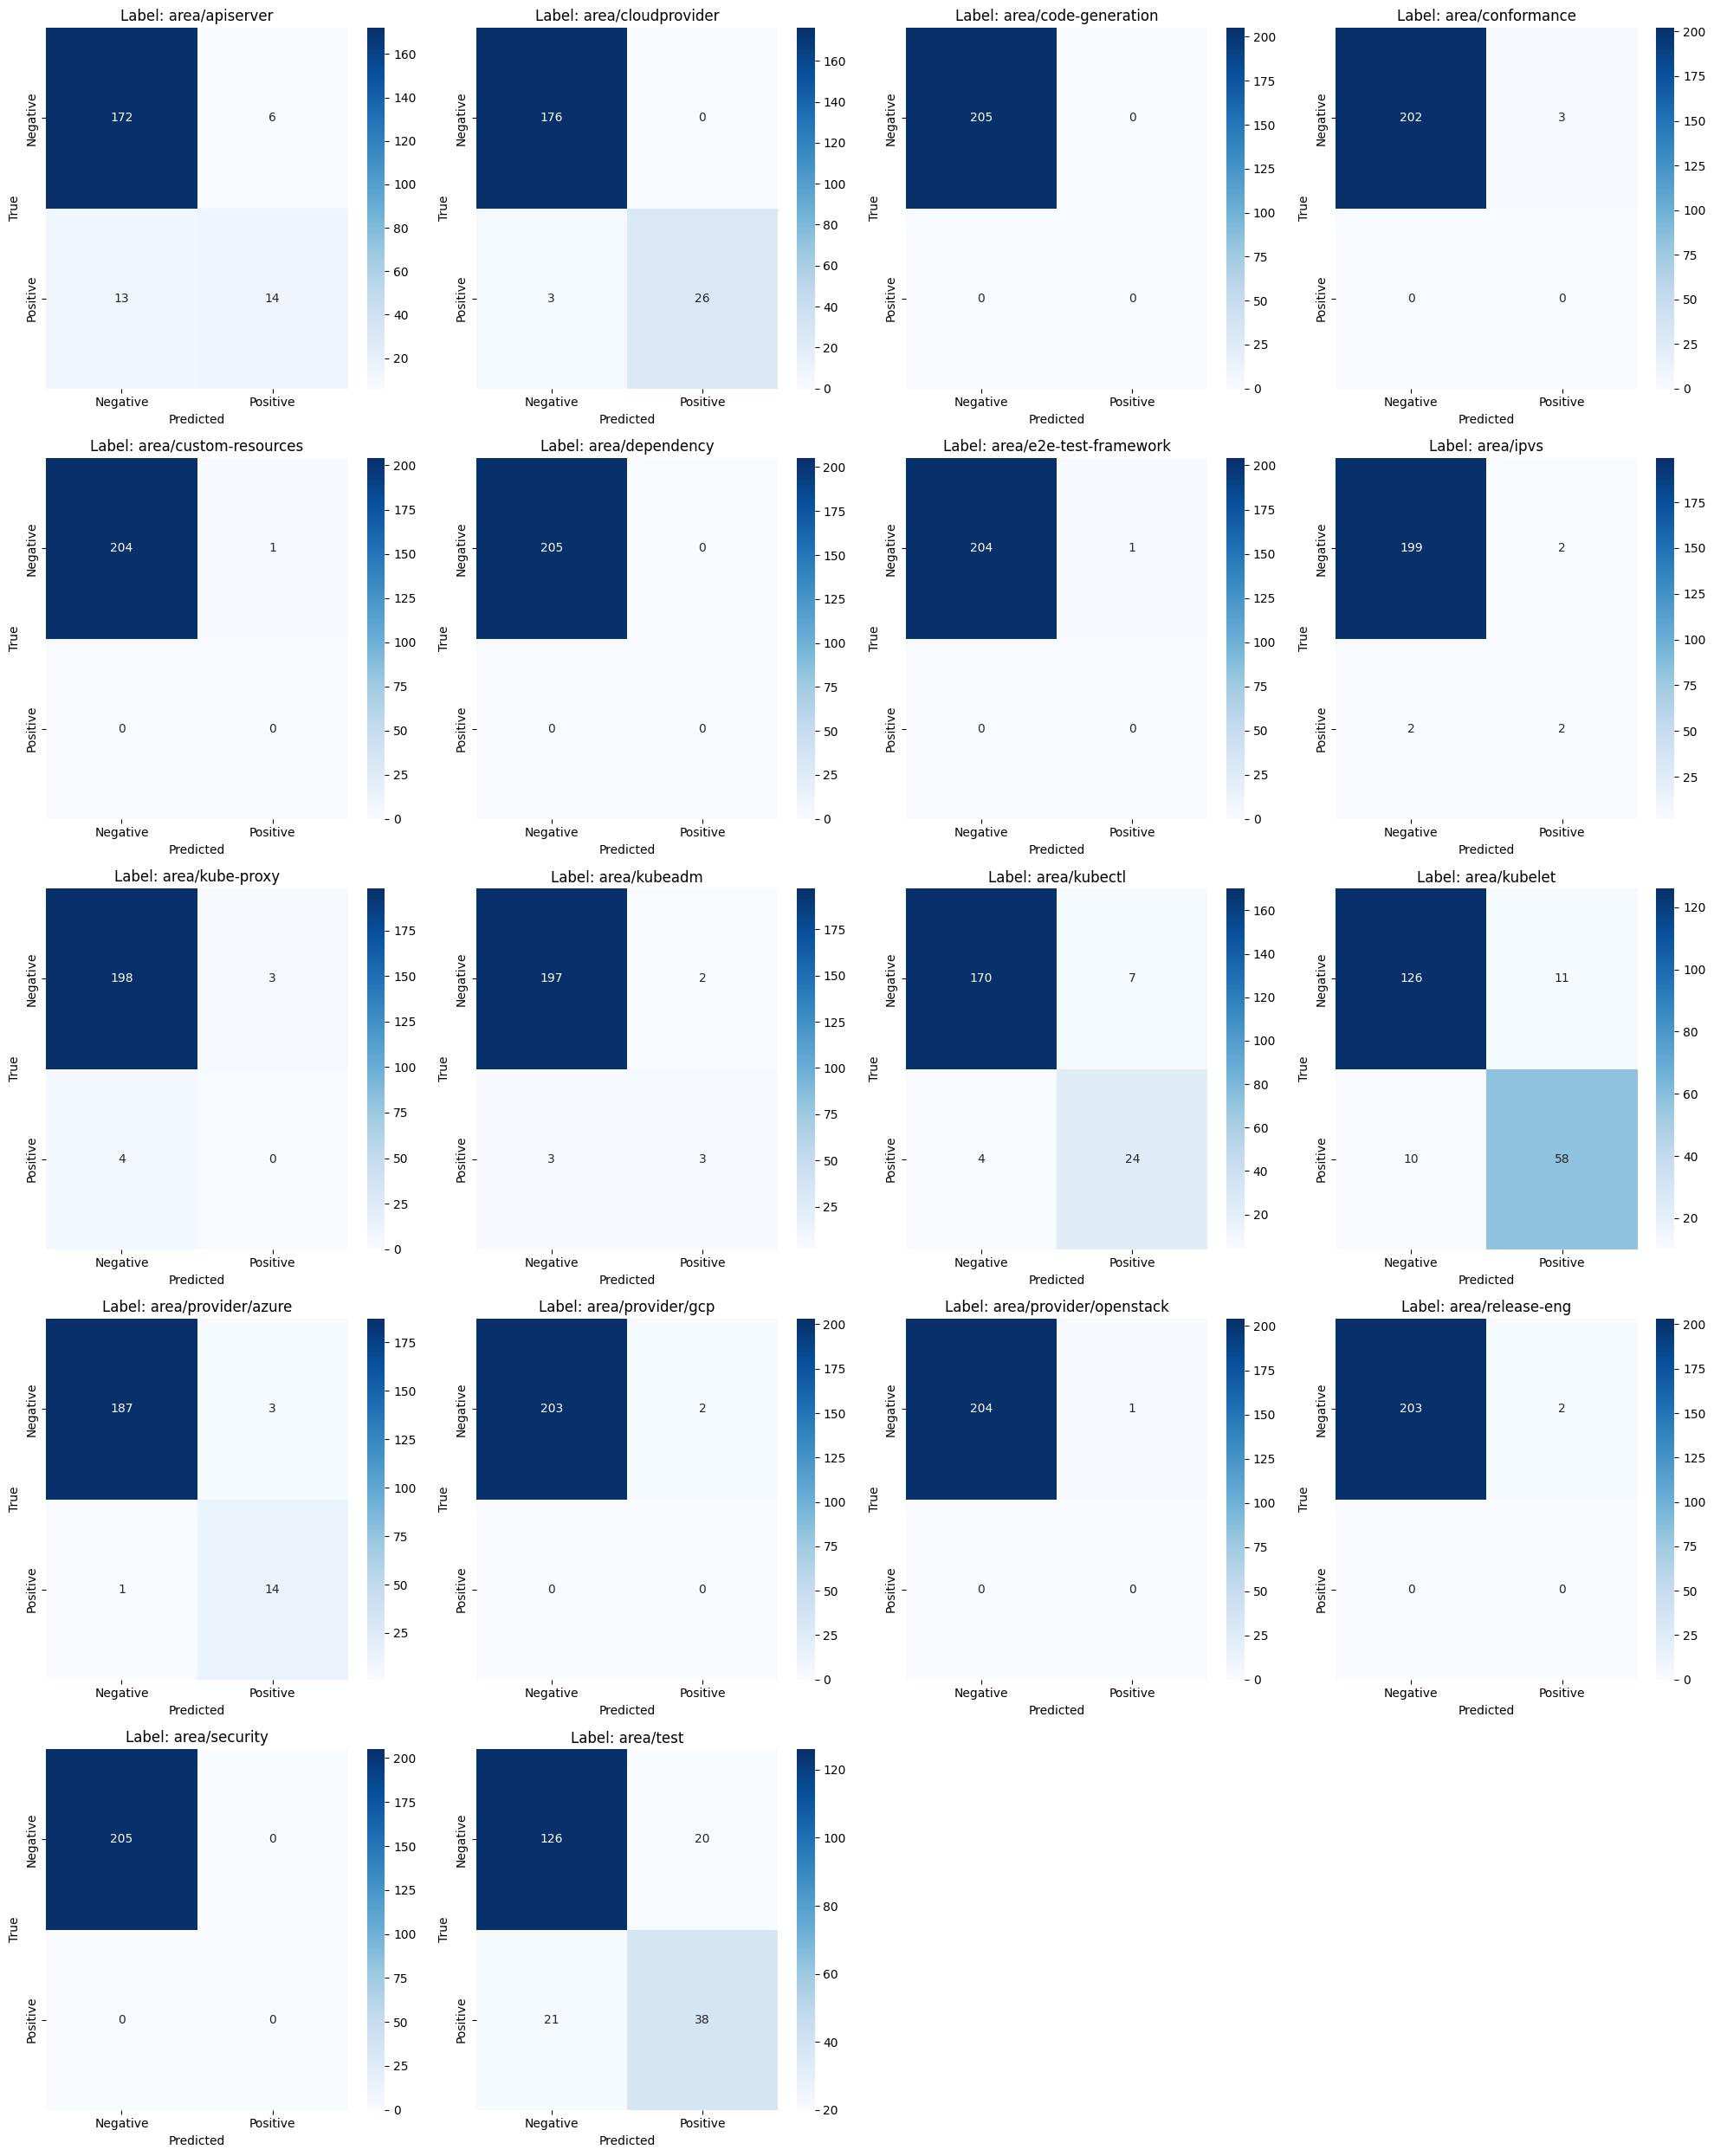

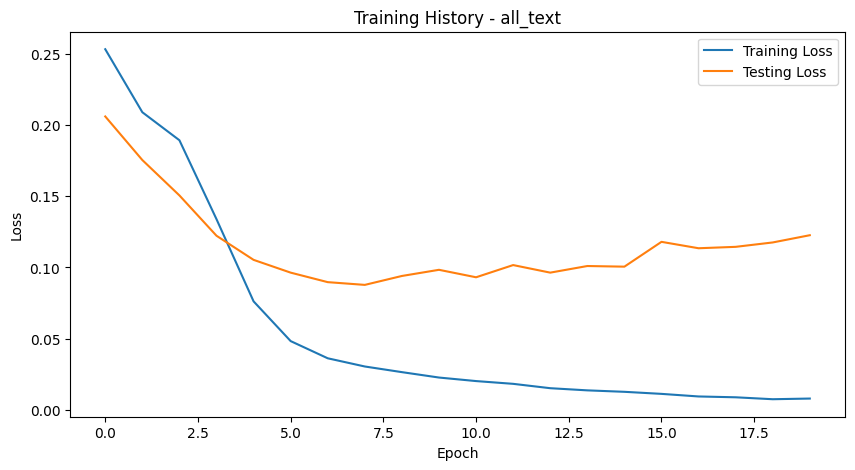

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # CNN hyperparameters
    parser.add_argument('--cnn_filter_sizes', type=str, default='2,4,6,8,10',
                        help='Comma-separated list of filter sizes for CNN layers')
    parser.add_argument('--cnn_num_filters', type=int, default=64,
                        help='Number of filters per size in CNN layers')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', 
                        help='Enable predefined set of labels instead of using all labels')
    parser.add_argument('--num_labels', type=int, choices=[10, 15], default=15,
                        help='Number of predefined labels to use (10 or 15)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## 15 Labels

Using 2 GPUs: [0, 1]
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

Loading training data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv...
Loading testing data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 3470/3470 [00:15<00:00, 216.91it/s]


Token length statistics before filtering:
  Mean: 414.33, Std Dev: 307.77
  Min: 20, Max: 4935
  25th percentile: 326.00
  50th percentile (median): 371.00
  75th percentile: 431.00
Applied 3.0 std dev threshold: (1.00, 1337.63)
Removed 81 samples by std dev filtering (2.33% of data)
Total removed: 81 samples (2.33% of original data)
Remaining: 3389 samples (97.67% of original data)

Token length statistics after all filtering:
  Mean: 375.89, Std Dev: 157.73
  Min: 20, Max: 1329
  25th percentile: 325.00
  50th percentile (median): 369.00
  75th percentile: 425.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 3389
Dataset size after basic cleaning: 3389 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 3389 (100.00% of data)

Step 5: Filtering infrequent label c

Calculating token lengths: 100%|██████████| 223/223 [00:00<00:00, 260.67it/s]


Token length statistics before filtering:
  Mean: 571.55, Std Dev: 542.14
  Min: 9, Max: 2920
  25th percentile: 206.00
  50th percentile (median): 400.00
  75th percentile: 723.50
Applied 3.0 std dev threshold: (1.00, 2197.96)
Removed 4 samples by std dev filtering (1.79% of data)
Total removed: 4 samples (1.79% of original data)
Remaining: 219 samples (98.21% of original data)

Token length statistics after all filtering:
  Mean: 530.96, Std Dev: 454.60
  Min: 9, Max: 2159
  25th percentile: 205.50
  50th percentile (median): 387.00
  75th percentile: 681.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 219
Dataset size after basic cleaning: 219 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 9 infrequent labels (50.00% of labels)
Number of labels remaining: 9 (50.00% of labels)
Removed 12 samples with no labels
Samples remaining after label filtering: 207 (94.52% of data)

Step 5: Filt

Calculating token lengths: 100%|██████████| 205/205 [00:00<00:00, 304.63it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 1329
  Mean token length: 375.36
  Median token length: 369.00
Testing set:
  Maximum token length: 2159
  Mean token length: 530.99
  Median token length: 400.00
Encoding labels...
Training set label density: 0.0580
Average labels per sample: 1.04
Using predefined labels: True

Using predefined list of 15 labels...
Using 15 predefined labels (from --num_labels=15): ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/release-eng' 'area/provider/azure' 'area/kubectl'
 'area/kube-proxy' 'area/code-generation' 'area/kubeadm' 'area/test'
 'area/provider/gcp' 'area/security' 'area/conformance']
Removed 581 training samples with no labels after feature selection
Removed 0 testing samples with no labels after feature selection
Remaining training samples: 2792
Remaining testing samples: 205
Training with 15 selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apis

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

Initialized DeBERTa-CNN model with 5 filter sizes and 64 filters per size
Model wrapped in DataParallel
Starting training for 30 epochs...

Epoch 1/30



Training: 100%|██████████| 88/88 [02:10<00:00,  1.48s/it]


Train Loss: 0.2887, Train Accuracy (Exact Match): 0.0007
Test Loss: 0.2424
Test Accuracy (Exact Match): 0.0000
Test Accuracy (Partial Match): 0.0000
Test Accuracy (Jaccard): 0.0000
Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Saved initial model to ./results/deberta_cnn_run_20250529_142231_all_text/best_model_deberta_cnn_all_text.pt as baseline

Epoch 2/30


Training: 100%|██████████| 88/88 [02:20<00:00,  1.60s/it]


Train Loss: 0.2374, Train Accuracy (Exact Match): 0.0014
Test Loss: 0.2118
Test Accuracy (Exact Match): 0.0000
Test Accuracy (Partial Match): 0.0000
Test Accuracy (Jaccard): 0.0000
Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000

Epoch 3/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.2212, Train Accuracy (Exact Match): 0.0050
Test Loss: 0.1848
Test Accuracy (Exact Match): 0.0244
Test Accuracy (Partial Match): 0.0390
Test Accuracy (Jaccard): 0.0341
Test Precision: 0.0390, Test Recall: 0.0390, Test F1: 0.0374
Saved new best model to ./results/deberta_cnn_run_20250529_142231_all_text/best_model_deberta_cnn_all_text.pt

Epoch 4/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.1744, Train Accuracy (Exact Match): 0.1032
Test Loss: 0.1531
Test Accuracy (Exact Match): 0.3854
Test Accuracy (Partial Match): 0.4293
Test Accuracy (Jaccard): 0.4146
Test Precision: 0.4293, Test Recall: 0.4293, Test F1: 0.4244
Saved new best model to ./results/deberta_cnn_run_20250529_142231_all_text/best_model_deberta_cnn_all_text.pt

Epoch 5/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.1079, Train Accuracy (Exact Match): 0.5168
Test Loss: 0.1308
Test Accuracy (Exact Match): 0.4927
Test Accuracy (Partial Match): 0.5854
Test Accuracy (Jaccard): 0.5512
Test Precision: 0.5756, Test Recall: 0.5854, Test F1: 0.5707
Saved new best model to ./results/deberta_cnn_run_20250529_142231_all_text/best_model_deberta_cnn_all_text.pt

Epoch 6/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0181, Train Accuracy (Exact Match): 0.9212
Test Loss: 0.1120
Test Accuracy (Exact Match): 0.5805
Test Accuracy (Partial Match): 0.7390
Test Accuracy (Jaccard): 0.6764
Test Precision: 0.7098, Test Recall: 0.7390, Test F1: 0.7089

Epoch 16/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0160, Train Accuracy (Exact Match): 0.9280
Test Loss: 0.1236
Test Accuracy (Exact Match): 0.5902
Test Accuracy (Partial Match): 0.7049
Test Accuracy (Jaccard): 0.6683
Test Precision: 0.7114, Test Recall: 0.7049, Test F1: 0.6951

Epoch 17/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0154, Train Accuracy (Exact Match): 0.9309
Test Loss: 0.1168
Test Accuracy (Exact Match): 0.6195
Test Accuracy (Partial Match): 0.7756
Test Accuracy (Jaccard): 0.7106
Test Precision: 0.7382, Test Recall: 0.7756, Test F1: 0.7415

Epoch 18/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0131, Train Accuracy (Exact Match): 0.9427
Test Loss: 0.1229
Test Accuracy (Exact Match): 0.6244
Test Accuracy (Partial Match): 0.7756
Test Accuracy (Jaccard): 0.7130
Test Precision: 0.7423, Test Recall: 0.7756, Test F1: 0.7439

Epoch 19/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0117, Train Accuracy (Exact Match): 0.9506
Test Loss: 0.1267
Test Accuracy (Exact Match): 0.6244
Test Accuracy (Partial Match): 0.7512
Test Accuracy (Jaccard): 0.7041
Test Precision: 0.7398, Test Recall: 0.7512, Test F1: 0.7317

Epoch 20/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Train Loss: 0.0099, Train Accuracy (Exact Match): 0.9610
Test Loss: 0.1337
Test Accuracy (Exact Match): 0.5756
Test Accuracy (Partial Match): 0.7268
Test Accuracy (Jaccard): 0.6650
Test Precision: 0.6927, Test Recall: 0.7268, Test F1: 0.6951

Epoch 21/30


Training: 100%|██████████| 88/88 [02:22<00:00,  1.62s/it]


Early stopping triggered
Train Loss: 0.0100, Train Accuracy (Exact Match): 0.9559
Test Loss: 0.1353
Test Accuracy (Exact Match): 0.5951
Test Accuracy (Partial Match): 0.7561
Test Accuracy (Jaccard): 0.6870
Test Precision: 0.7130, Test Recall: 0.7561, Test F1: 0.7187
Early stopping triggered. Terminating training.

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.6244
Partial Match Accuracy: 0.7756
Jaccard Similarity: 0.7154
Precision: 0.7463
Recall: 0.7756
F1 Score: 0.7463

Training completed! Results saved to ./results/deberta_cnn_run_20250529_142231_all_text


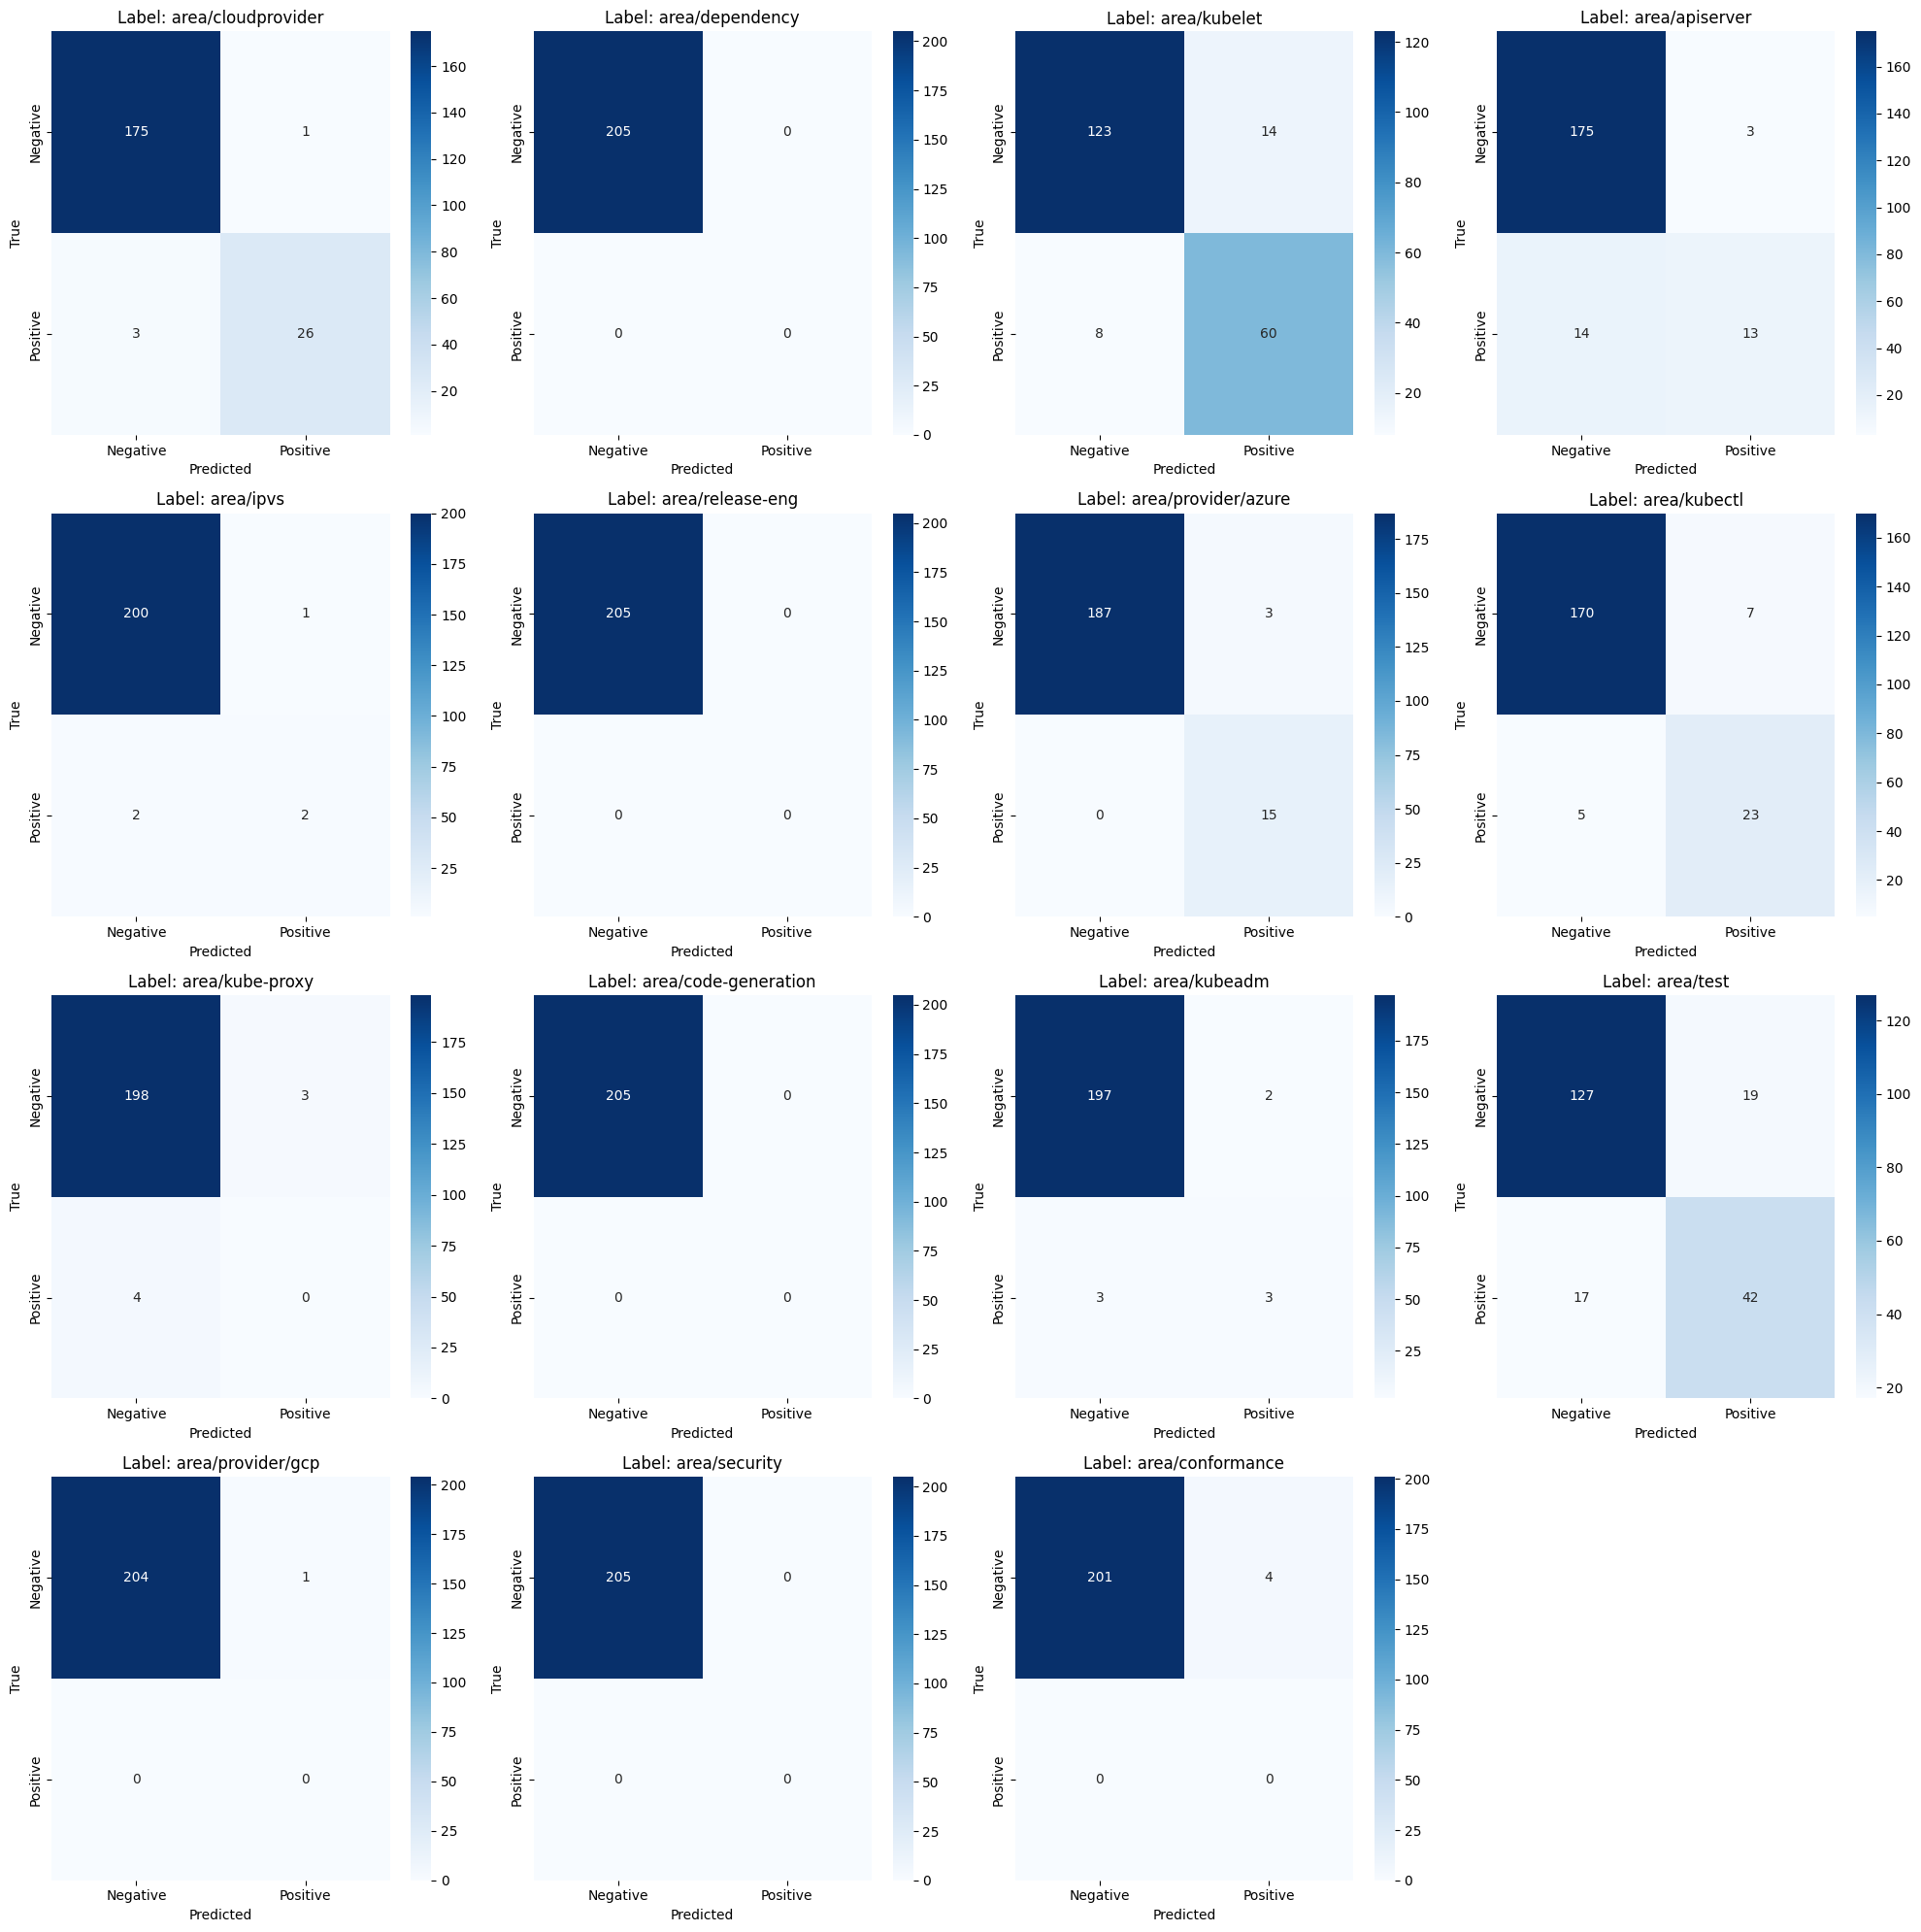

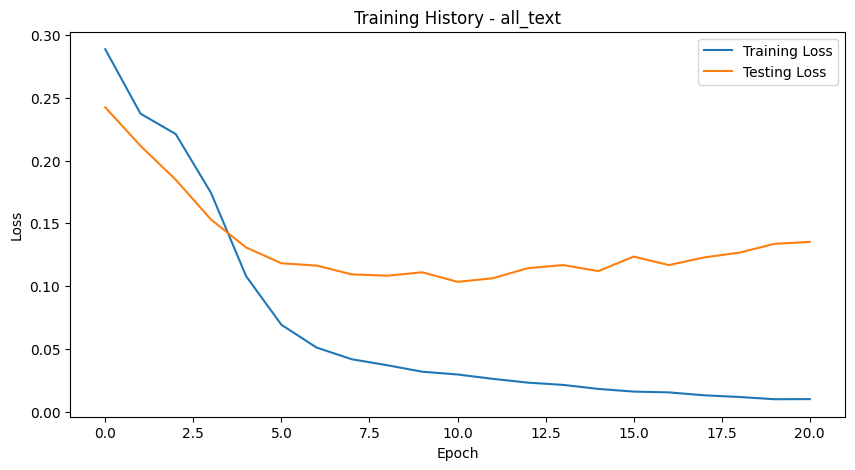

In [2]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # CNN hyperparameters
    parser.add_argument('--cnn_filter_sizes', type=str, default='2,4,6,8,10',
                        help='Comma-separated list of filter sizes for CNN layers')
    parser.add_argument('--cnn_num_filters', type=int, default=64,
                        help='Number of filters per size in CNN layers')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true',default=True, 
                        help='Enable predefined set of labels instead of using all labels')
    parser.add_argument('--num_labels', type=int, choices=[10, 15], default=15,
                        help='Number of predefined labels to use (10 or 15)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)

## 10 Labels

Using 2 GPUs: [0, 1]
Loading tokenizer...
Loading training data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv...
Loading testing data from /kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv...

=== PROCESSING TRAINING DATA ===

Applying token length filtering to training data...


Calculating token lengths: 100%|██████████| 3470/3470 [00:15<00:00, 217.10it/s]


Token length statistics before filtering:
  Mean: 414.33, Std Dev: 307.77
  Min: 20, Max: 4935
  25th percentile: 326.00
  50th percentile (median): 371.00
  75th percentile: 431.00
Applied 3.0 std dev threshold: (1.00, 1337.63)
Removed 81 samples by std dev filtering (2.33% of data)
Total removed: 81 samples (2.33% of original data)
Remaining: 3389 samples (97.67% of original data)

Token length statistics after all filtering:
  Mean: 375.89, Std Dev: 157.73
  Min: 20, Max: 1329
  25th percentile: 325.00
  50th percentile (median): 369.00
  75th percentile: 425.00

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 3389
Dataset size after basic cleaning: 3389 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 0 infrequent labels (0.00% of labels)
Number of labels remaining: 18 (100.00% of labels)
Samples remaining after label filtering: 3389 (100.00% of data)

Step 5: Filtering infrequent label c

Calculating token lengths: 100%|██████████| 223/223 [00:00<00:00, 246.20it/s]


Token length statistics before filtering:
  Mean: 571.55, Std Dev: 542.14
  Min: 9, Max: 2920
  25th percentile: 206.00
  50th percentile (median): 400.00
  75th percentile: 723.50
Applied 3.0 std dev threshold: (1.00, 2197.96)
Removed 4 samples by std dev filtering (1.79% of data)
Total removed: 4 samples (1.79% of original data)
Remaining: 219 samples (98.21% of original data)

Token length statistics after all filtering:
  Mean: 530.96, Std Dev: 454.60
  Min: 9, Max: 2159
  25th percentile: 205.50
  50th percentile (median): 387.00
  75th percentile: 681.50

=== DATA PREPROCESSING STATISTICS ===
Initial dataset size: 219
Dataset size after basic cleaning: 219 (100.00% of original data)

Step 4: Filtering infrequent labels (min frequency: 5)
Total unique labels before filtering: 18
Removed 9 infrequent labels (50.00% of labels)
Number of labels remaining: 9 (50.00% of labels)
Removed 12 samples with no labels
Samples remaining after label filtering: 207 (94.52% of data)

Step 5: Filt

Calculating token lengths: 100%|██████████| 205/205 [00:00<00:00, 300.03it/s]



=== TOKEN LENGTH SUMMARY ===
Training set:
  Maximum token length: 1329
  Mean token length: 375.36
  Median token length: 369.00
Testing set:
  Maximum token length: 2159
  Mean token length: 530.99
  Median token length: 400.00
Encoding labels...
Training set label density: 0.0580
Average labels per sample: 1.04
Using predefined labels: True

Using predefined list of 15 labels...
Using 10 predefined labels (from --num_labels=10): ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/security' 'area/provider/azure' 'area/kubectl'
 'area/kube-proxy' 'area/code-generation']
Removed 1474 training samples with no labels after feature selection
Removed 47 testing samples with no labels after feature selection
Remaining training samples: 1899
Remaining testing samples: 158
Training with 10 selected labels: ['area/cloudprovider' 'area/dependency' 'area/kubelet' 'area/apiserver'
 'area/ipvs' 'area/security' 'area/provider/azure' 'area/kubectl'
 'area/kube

Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.3577, Train Accuracy (Exact Match): 0.0026
Test Loss: 0.2994
Test Accuracy (Exact Match): 0.0000
Test Accuracy (Partial Match): 0.0000
Test Accuracy (Jaccard): 0.0000
Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000
Saved initial model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt as baseline

Epoch 2/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.3069, Train Accuracy (Exact Match): 0.0079
Test Loss: 0.2661
Test Accuracy (Exact Match): 0.0570
Test Accuracy (Partial Match): 0.0570
Test Accuracy (Jaccard): 0.0570
Test Precision: 0.0570, Test Recall: 0.0570, Test F1: 0.0570
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 3/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.2865, Train Accuracy (Exact Match): 0.0263
Test Loss: 0.2285
Test Accuracy (Exact Match): 0.3165
Test Accuracy (Partial Match): 0.3228
Test Accuracy (Jaccard): 0.3228
Test Precision: 0.3291, Test Recall: 0.3228, Test F1: 0.3249
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 4/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.2392, Train Accuracy (Exact Match): 0.1232
Test Loss: 0.1717
Test Accuracy (Exact Match): 0.5380
Test Accuracy (Partial Match): 0.6139
Test Accuracy (Jaccard): 0.5886
Test Precision: 0.6139, Test Recall: 0.6139, Test F1: 0.6055
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 5/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.1519, Train Accuracy (Exact Match): 0.5292
Test Loss: 0.1320
Test Accuracy (Exact Match): 0.6646
Test Accuracy (Partial Match): 0.7152
Test Accuracy (Jaccard): 0.6930
Test Precision: 0.6994, Test Recall: 0.7152, Test F1: 0.7025
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 6/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0948, Train Accuracy (Exact Match): 0.7762
Test Loss: 0.1119
Test Accuracy (Exact Match): 0.7278
Test Accuracy (Partial Match): 0.7753
Test Accuracy (Jaccard): 0.7563
Test Precision: 0.7658, Test Recall: 0.7753, Test F1: 0.7658
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 7/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0651, Train Accuracy (Exact Match): 0.8710
Test Loss: 0.1033
Test Accuracy (Exact Match): 0.7089
Test Accuracy (Partial Match): 0.7816
Test Accuracy (Jaccard): 0.7500
Test Precision: 0.7595, Test Recall: 0.7816, Test F1: 0.7637

Epoch 8/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0477, Train Accuracy (Exact Match): 0.9063
Test Loss: 0.0995
Test Accuracy (Exact Match): 0.7595
Test Accuracy (Partial Match): 0.8038
Test Accuracy (Jaccard): 0.7848
Test Precision: 0.7911, Test Recall: 0.8038, Test F1: 0.7932
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 9/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0412, Train Accuracy (Exact Match): 0.9121
Test Loss: 0.0989
Test Accuracy (Exact Match): 0.7215
Test Accuracy (Partial Match): 0.8386
Test Accuracy (Jaccard): 0.7848
Test Precision: 0.7943, Test Recall: 0.8386, Test F1: 0.8059
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 10/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.0332, Train Accuracy (Exact Match): 0.9284
Test Loss: 0.1048
Test Accuracy (Exact Match): 0.7342
Test Accuracy (Partial Match): 0.8070
Test Accuracy (Jaccard): 0.7753
Test Precision: 0.7848, Test Recall: 0.8070, Test F1: 0.7890

Epoch 11/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0295, Train Accuracy (Exact Match): 0.9336
Test Loss: 0.0990
Test Accuracy (Exact Match): 0.7658
Test Accuracy (Partial Match): 0.8354
Test Accuracy (Jaccard): 0.8038
Test Precision: 0.8101, Test Recall: 0.8354, Test F1: 0.8165
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt

Epoch 12/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0247, Train Accuracy (Exact Match): 0.9426
Test Loss: 0.1084
Test Accuracy (Exact Match): 0.7658
Test Accuracy (Partial Match): 0.8228
Test Accuracy (Jaccard): 0.7975
Test Precision: 0.8038, Test Recall: 0.8228, Test F1: 0.8080

Epoch 13/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0214, Train Accuracy (Exact Match): 0.9458
Test Loss: 0.1031
Test Accuracy (Exact Match): 0.7595
Test Accuracy (Partial Match): 0.8354
Test Accuracy (Jaccard): 0.8006
Test Precision: 0.8070, Test Recall: 0.8354, Test F1: 0.8143

Epoch 14/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.62s/it]


Train Loss: 0.0185, Train Accuracy (Exact Match): 0.9605
Test Loss: 0.1099
Test Accuracy (Exact Match): 0.7089
Test Accuracy (Partial Match): 0.7785
Test Accuracy (Jaccard): 0.7500
Test Precision: 0.7627, Test Recall: 0.7785, Test F1: 0.7637

Epoch 15/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.0148, Train Accuracy (Exact Match): 0.9652
Test Loss: 0.1093
Test Accuracy (Exact Match): 0.7658
Test Accuracy (Partial Match): 0.8259
Test Accuracy (Jaccard): 0.8006
Test Precision: 0.8101, Test Recall: 0.8259, Test F1: 0.8122

Epoch 16/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0134, Train Accuracy (Exact Match): 0.9731
Test Loss: 0.1248
Test Accuracy (Exact Match): 0.7278
Test Accuracy (Partial Match): 0.7975
Test Accuracy (Jaccard): 0.7690
Test Precision: 0.7816, Test Recall: 0.7975, Test F1: 0.7827

Epoch 17/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0114, Train Accuracy (Exact Match): 0.9763
Test Loss: 0.1322
Test Accuracy (Exact Match): 0.7215
Test Accuracy (Partial Match): 0.7880
Test Accuracy (Jaccard): 0.7595
Test Precision: 0.7690, Test Recall: 0.7880, Test F1: 0.7722

Epoch 18/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0094, Train Accuracy (Exact Match): 0.9795
Test Loss: 0.1159
Test Accuracy (Exact Match): 0.7658
Test Accuracy (Partial Match): 0.8196
Test Accuracy (Jaccard): 0.7975
Test Precision: 0.8070, Test Recall: 0.8196, Test F1: 0.8080

Epoch 19/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0078, Train Accuracy (Exact Match): 0.9863
Test Loss: 0.1335
Test Accuracy (Exact Match): 0.7405
Test Accuracy (Partial Match): 0.7911
Test Accuracy (Jaccard): 0.7722
Test Precision: 0.7848, Test Recall: 0.7911, Test F1: 0.7827

Epoch 20/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.0065, Train Accuracy (Exact Match): 0.9884
Test Loss: 0.1308
Test Accuracy (Exact Match): 0.7532
Test Accuracy (Partial Match): 0.8070
Test Accuracy (Jaccard): 0.7816
Test Precision: 0.7848, Test Recall: 0.8070, Test F1: 0.7911

Epoch 21/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Train Loss: 0.0061, Train Accuracy (Exact Match): 0.9858
Test Loss: 0.1280
Test Accuracy (Exact Match): 0.7405
Test Accuracy (Partial Match): 0.8165
Test Accuracy (Jaccard): 0.7880
Test Precision: 0.8070, Test Recall: 0.8165, Test F1: 0.8038

Epoch 22/30


Training: 100%|██████████| 60/60 [01:36<00:00,  1.61s/it]


Train Loss: 0.0058, Train Accuracy (Exact Match): 0.9895
Test Loss: 0.1297
Test Accuracy (Exact Match): 0.7911
Test Accuracy (Partial Match): 0.8165
Test Accuracy (Jaccard): 0.8101
Test Precision: 0.8228, Test Recall: 0.8165, Test F1: 0.8165

Epoch 23/30


Training: 100%|██████████| 60/60 [01:37<00:00,  1.62s/it]


Early stopping triggered
Train Loss: 0.0039, Train Accuracy (Exact Match): 0.9974
Test Loss: 0.1325
Test Accuracy (Exact Match): 0.7785
Test Accuracy (Partial Match): 0.8291
Test Accuracy (Jaccard): 0.8101
Test Precision: 0.8228, Test Recall: 0.8291, Test F1: 0.8207
Saved new best model to ./results/deberta_cnn_run_20250529_151548_all_text/best_model_deberta_cnn_all_text.pt
Early stopping triggered. Terminating training.

Loading best model for final evaluation...

Final evaluation with default threshold (0.5):
Exact Match Accuracy: 0.7785
Partial Match Accuracy: 0.8291
Jaccard Similarity: 0.8101
Precision: 0.8228
Recall: 0.8291
F1 Score: 0.8207

Training completed! Results saved to ./results/deberta_cnn_run_20250529_151548_all_text


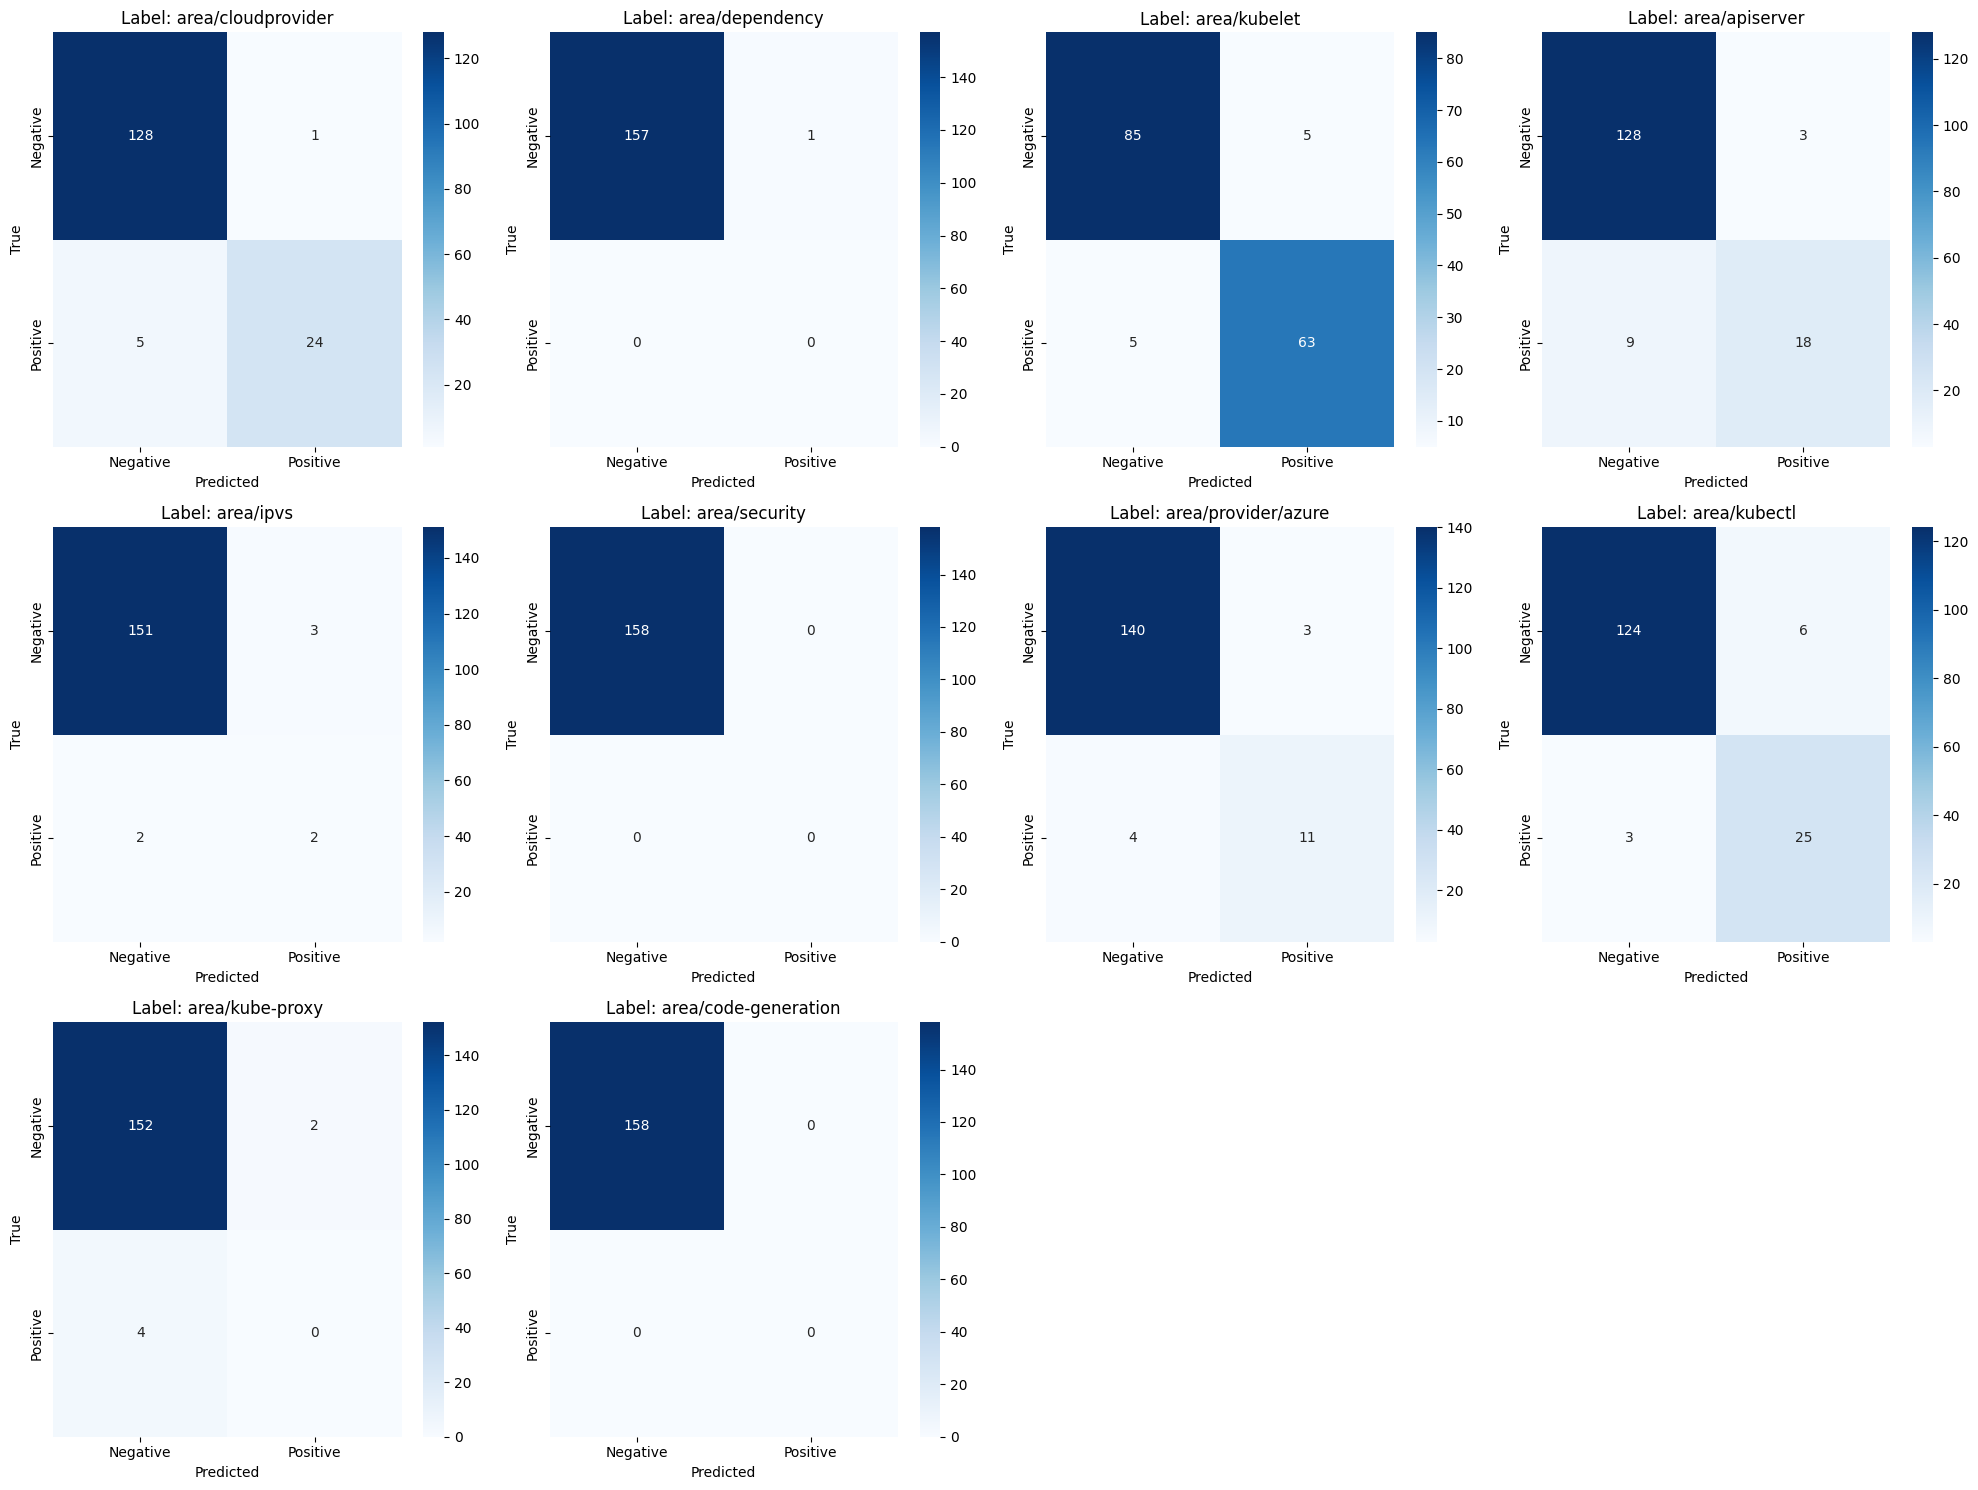

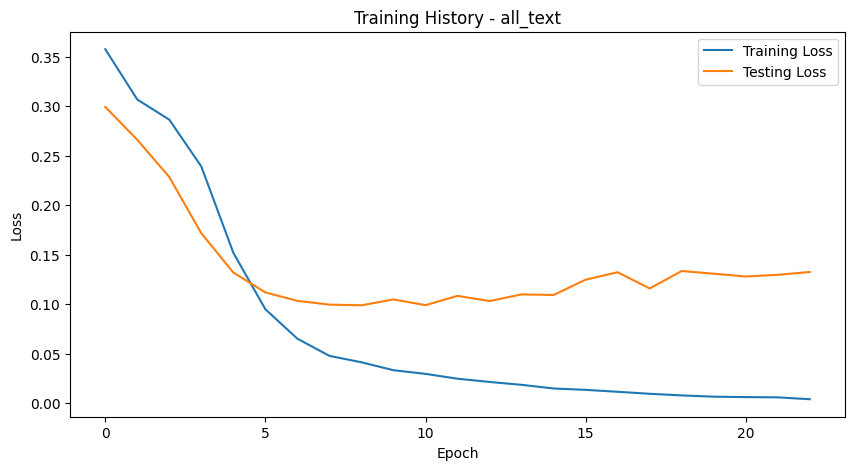

In [3]:
if __name__ == "__main__":
    # Create parser and handle Jupyter/Colab environment by ignoring unknown args
    parser = argparse.ArgumentParser(description='Train DeBERTa for multi-label classification')
    
    # Data parameters
    parser.add_argument('--train_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_augmented_train_data.csv",
                        help='Path to the CSV training data file')
    parser.add_argument('--test_data_path', type=str, 
                        default="/kaggle/input/bug-kubernetes-augmented-0-9/preprocessed_val_data.csv",
                        help='Path to the CSV testing data file')
    parser.add_argument('--text_column', type=str, default='all_text',
                        help='Column name with the text data to use for training (e.g., all_text, all_text_0.5)')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=2,
                        help='Maximum number of labels per sample (default: 5)')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Training batch size')
    parser.add_argument('--epochs', type=int, default=30, help='Number of training epochs')
    parser.add_argument('--learning_rate', type=float, default=2e-5, help='Learning rate')
    parser.add_argument('--patience', type=int, default=5, help='Early stopping patience')
    parser.add_argument('--use_class_weights', action='store_true', help='Use class weights for imbalanced data')
    
    # CNN hyperparameters
    parser.add_argument('--cnn_filter_sizes', type=str, default='2,4,6,8,10',
                        help='Comma-separated list of filter sizes for CNN layers')
    parser.add_argument('--cnn_num_filters', type=int, default=64,
                        help='Number of filters per size in CNN layers')
    
    # Token length parameters
    parser.add_argument('--max_length', type=int, default=512, help='Maximum token length for model input')
    
    # Token length filtering parameters
    parser.add_argument('--token_length_filter', type=str, choices=['2std', '3std', None], default='3std',
                        help='Remove token length outliers based on standard deviation threshold')
    parser.add_argument('--min_token_threshold', type=int, default=None,
                        help='Minimum number of tokens required for a sample')
    
    # Token reduction parameters for handling long tokens
    parser.add_argument('--token_reduction_strategy', type=str, 
                        choices=['simple', 'smart_truncation', 'extractive_summarization', 'hybrid'], 
                        default=None,
                        help='Strategy to handle long tokens exceeding max_length: '
                             'simple=simple truncation, '
                             'smart_truncation=keep beginning and end, '
                             'extractive_summarization=extract key sentences, '
                             'hybrid=combine summarization and truncation')
    
    # Label selection parameters
    parser.add_argument('--use_predefined_labels', action='store_true', default=True,
                        help='Enable predefined set of labels instead of using all labels')
    parser.add_argument('--num_labels', type=int, choices=[10, 15], default=10,
                        help='Number of predefined labels to use (10 or 15)')
    
    # Parse arguments, ignore unknown args for compatibility with Jupyter/Colab
    args, unknown = parser.parse_known_args()
    
    # If the script is run directly, not imported
    results = main(args)